## 6a. Advanced Modelling - London Marathon
__Project - BSTN Capstone__
<br>__Beth McGregor__

#### Introduction
This notebook follows __5. Data Amalgamation, Exploratory Data Analysis, Data Transformation and Basic Modelling__. First, the all features data for the London Marathon will be loaded, transformed and used for advanced modelling to see if improvement can be achieved. 

In [1]:
# Load the required libraries for this notebook

import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Analysis
from scipy import stats
import statsmodels.api as sm
## Tukey's HSD
from statsmodels.stats import multicomp

# Data Transformation
from sklearn.preprocessing import OneHotEncoder

# Modelling
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import joblib

#### Look at a reduced dataset (London only) with additional features

In [168]:
# Load in the london all features dataset
london_all_features_df = pd.read_csv('Data/london/output/london_results_all_features_df.csv')
london_all_features_df.head()

,Unnamed: 0,marathon_name,year,place_overall,full_name,bib_number,age_class,elite_status,half_split_seconds,nationality,...,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,elevation_loss,course_turns,temperature_min,temperature_max,precipitation
0,0,london,2019,1,Weynay Ghebresilasie,1451,18-39,0,3904,ERI,...,39.75,6.95,5.5,-10.3,137.4,-170.2,56,7.1,16.1,0.0
1,1,london,2019,2,John Gilbert,1291,18-39,0,4080,GBR,...,39.75,6.95,5.5,-10.3,137.4,-170.2,56,7.1,16.1,0.0
2,2,london,2019,3,Ben Johnson,1246,18-39,0,4162,GBR,...,39.75,6.95,5.5,-10.3,137.4,-170.2,56,7.1,16.1,0.0
3,3,london,2019,4,Alex Milne,1456,18-39,0,4170,GBR,...,39.75,6.95,5.5,-10.3,137.4,-170.2,56,7.1,16.1,0.0
4,4,london,2019,5,Craig Ruddy,1362,18-39,0,4078,GBR,...,39.75,6.95,5.5,-10.3,137.4,-170.2,56,7.1,16.1,0.0


In [169]:
# Drop the 'Unnamed: 0' column
london_all_features_df.drop('Unnamed: 0', axis = 1, inplace = True)

In [170]:
# Get the shape of the dataframe
london_all_features_df.shape

(231962, 21)

In [171]:
# Look at the data types
london_all_features_df.dtypes

marathon_name           object
year                     int64
place_overall            int64
full_name               object
bib_number               int64
age_class               object
elite_status             int64
half_split_seconds       int64
nationality             object
gender                  object
finish_time_seconds      int64
altitude_start         float64
altitude_finish        float64
max_slope              float64
min_slope              float64
elevation_gain         float64
elevation_loss         float64
course_turns             int64
temperature_min        float64
temperature_max        float64
precipitation          float64
dtype: object

Data types appear to be appropriate. 

In [7]:
# Check that there are no missing values
london_all_features_df.isna().sum()

marathon_name          0
year                   0
place_overall          0
full_name              0
bib_number             0
age_class              0
elite_status           0
half_split_seconds     0
nationality            0
gender                 0
finish_time_seconds    0
altitude_start         0
altitude_finish        0
max_slope              0
min_slope              0
elevation_gain         0
elevation_loss         0
course_turns           0
temperature_min        0
temperature_max        0
precipitation          0
dtype: int64

There are no missing values present. 

#### Start to Explore the Numeric Columns: 

In [8]:
london_numeric_columns_df = london_all_features_df[['year', 'place_overall', 'bib_number', 'elite_status', 'half_split_seconds', 'finish_time_seconds', 'altitude_start', 'altitude_finish', 'max_slope', 'min_slope', 'elevation_gain', 'elevation_loss', 'course_turns', 'temperature_min', 'temperature_max', 'precipitation' ]]

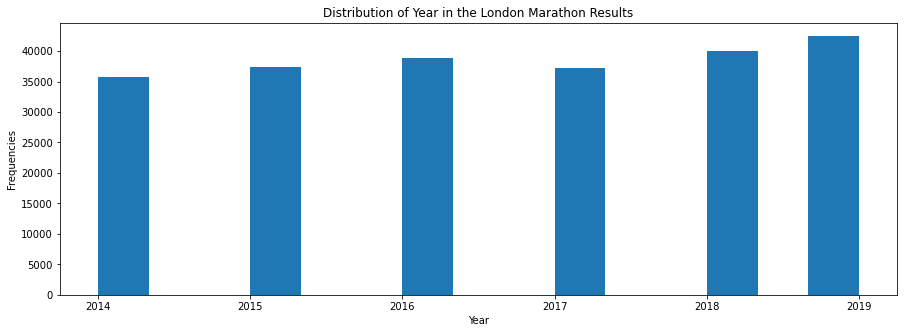

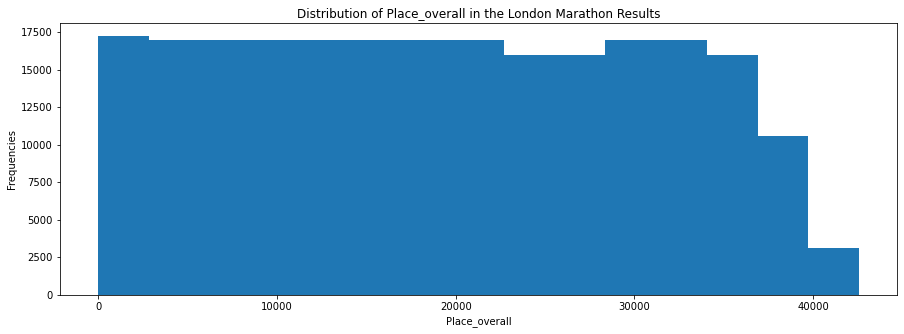

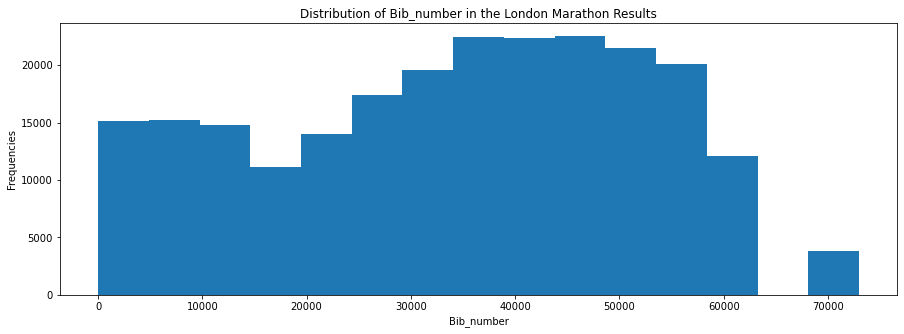

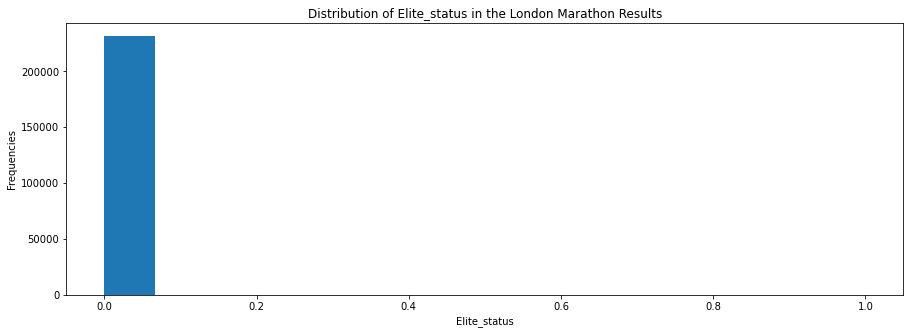

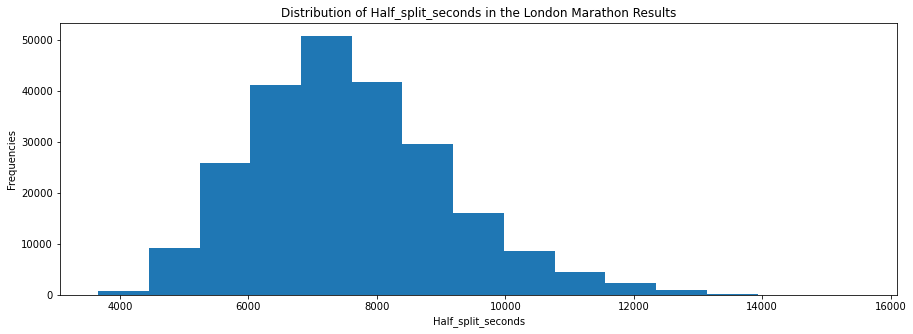

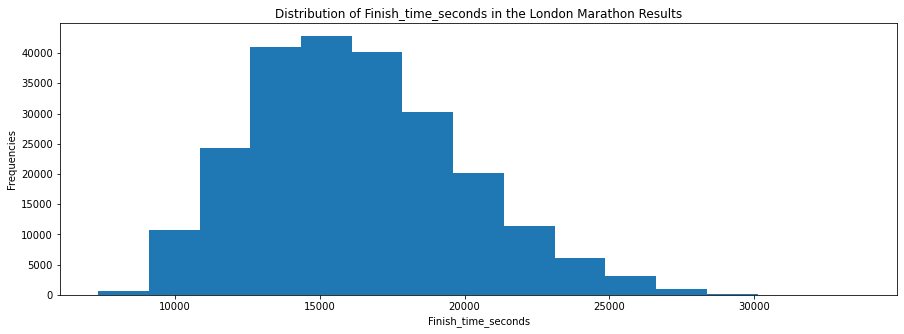

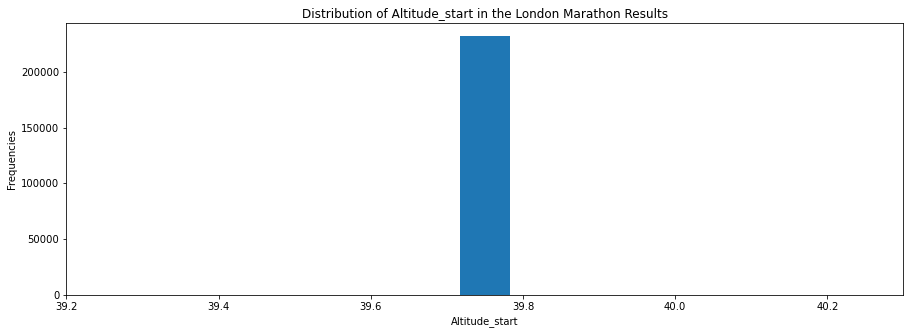

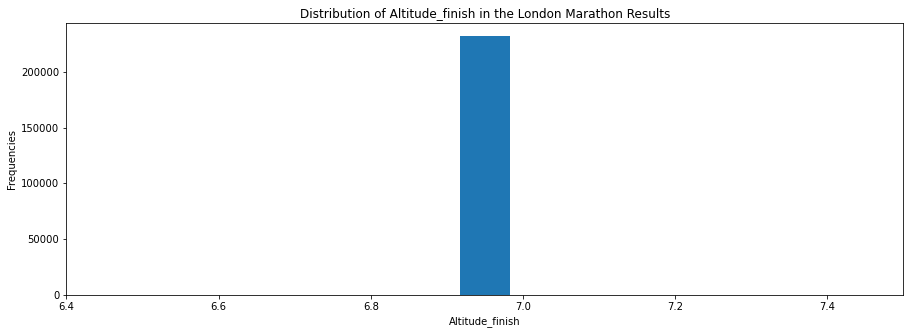

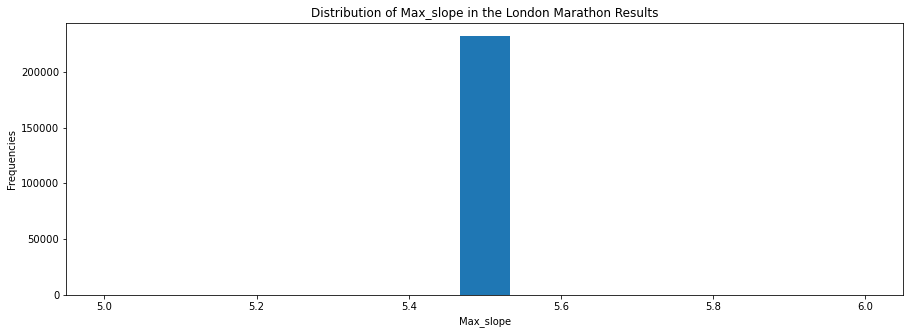

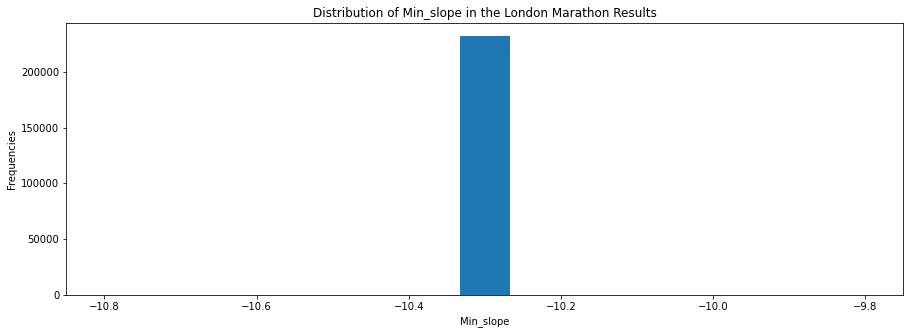

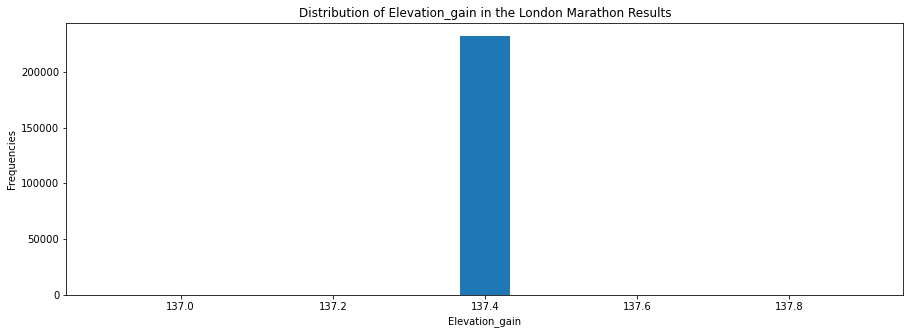

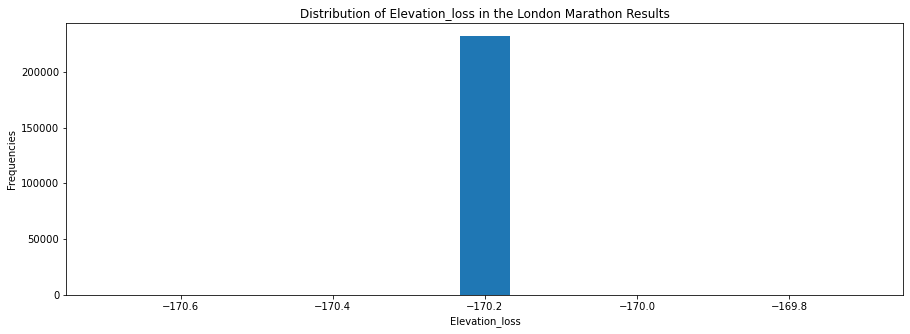

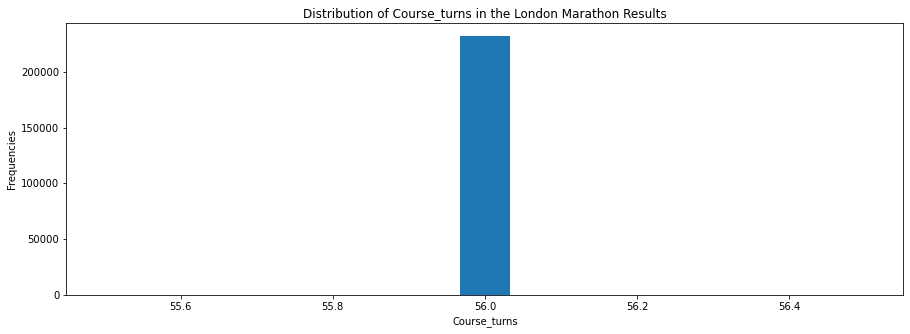

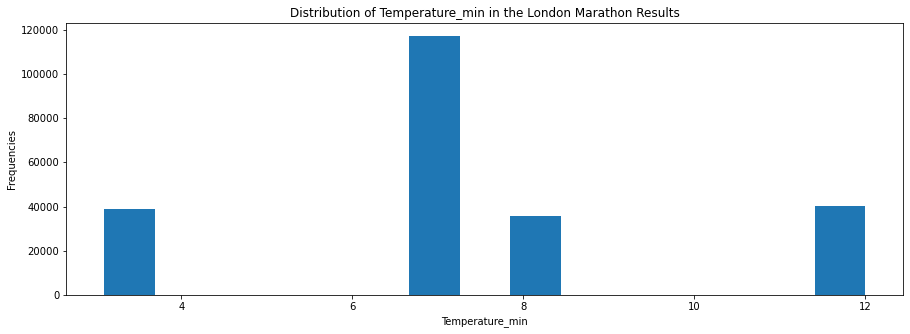

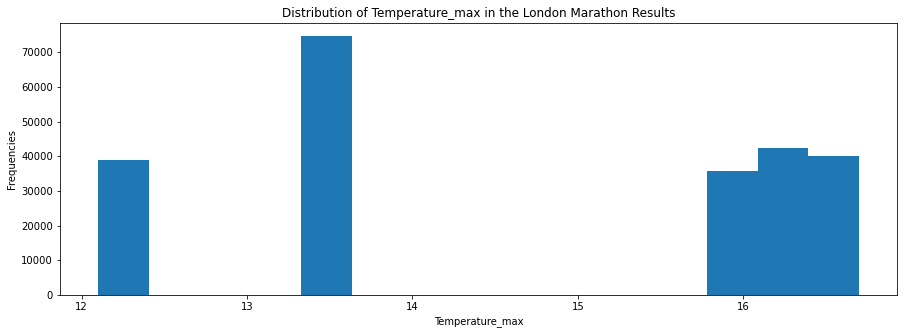

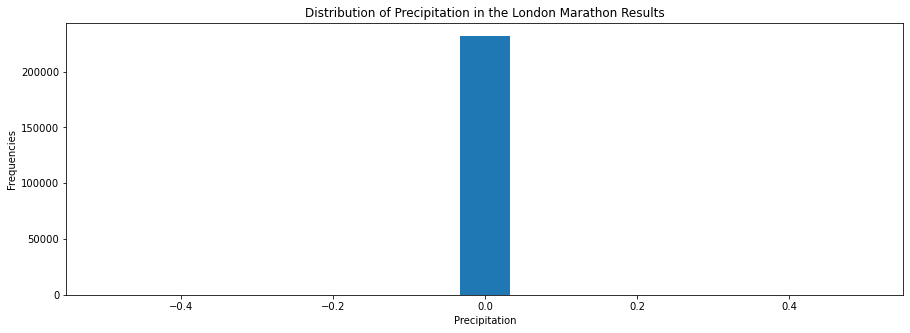

In [9]:
for col in london_numeric_columns_df:

    plt.figure(figsize=(15,5))
    plt.hist(london_numeric_columns_df[col], bins=15)
    plt.xlabel(col.capitalize())
    plt.ylabel("Frequencies")
    plt.title(f"Distribution of {col.capitalize()} in the London Marathon Results")
    plt.show()

The trends observed in the above plots follow the trends observed in the combined dataset. 

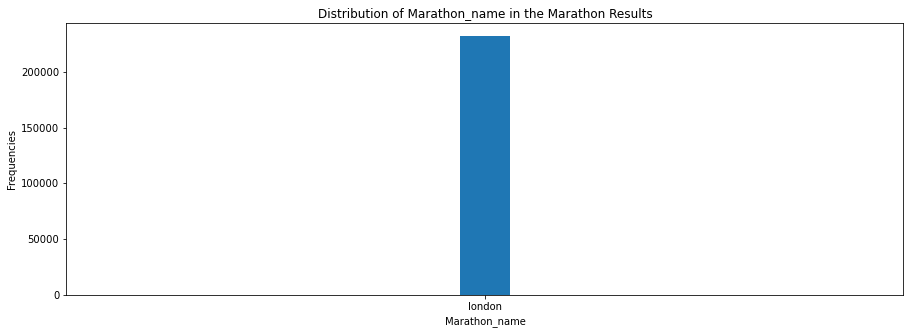

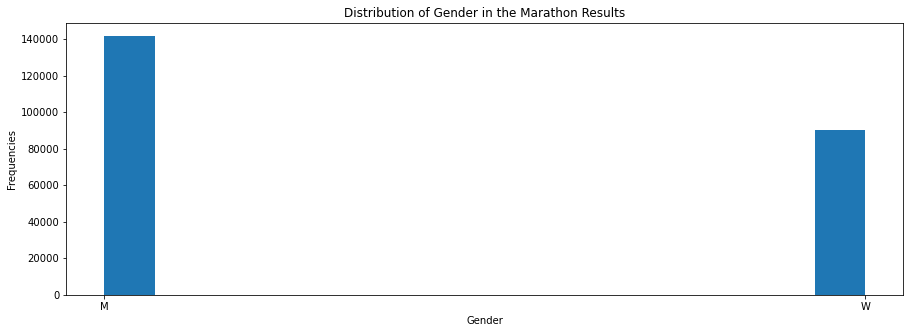

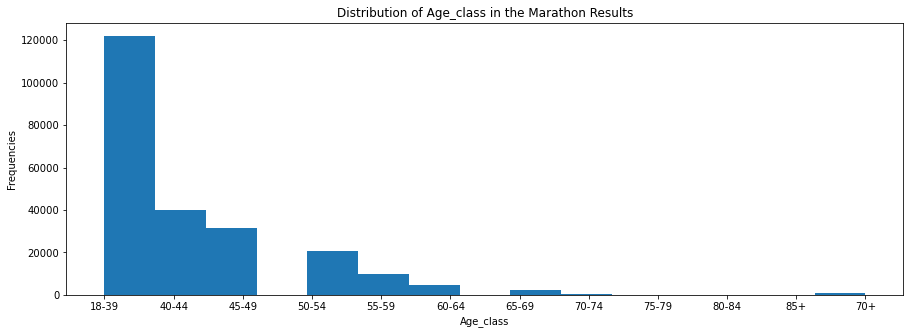

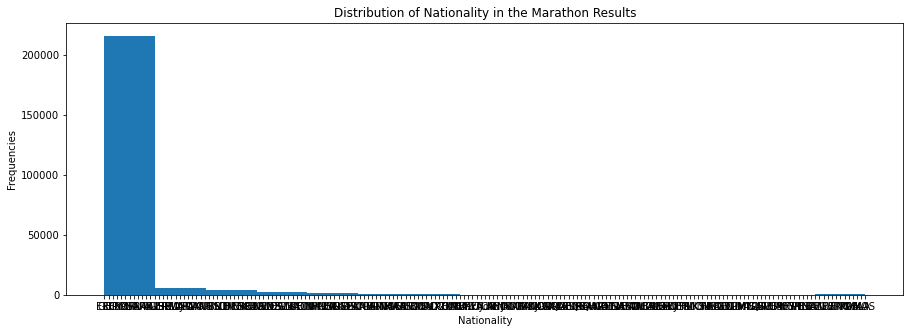

In [10]:
# Look at the distribution of data in the categorical columns
london_categorical_columns_df = london_all_features_df[['marathon_name', 'gender', 'age_class', 'nationality']]

for col in london_categorical_columns_df:

    plt.figure(figsize=(15,5))
    plt.hist(london_categorical_columns_df[col], bins=15)
    plt.xlabel(col.capitalize())
    plt.ylabel("Frequencies")
    plt.title(f"Distribution of {col.capitalize()} in the Marathon Results")
    plt.show()

The majority of runners fall in the 18-39 age category, with progressively fewer runners in the older age categories. 

#### Update the country codes in the nationality column to the IOC country codes

In [11]:
# Create a dictionary of the nationality country codes that need to be replaced (Used IOC Country Codes)

ioc_codes = {'DEU' : 'GER', 'ZWE' : 'ZIM', 'ZAF' : 'RSA', 'WLS' : 'GBR', 'WLF' : 'FRA', 'VNM' : 'VIE', 
             'URY' : 'URU', 'UMI' : 'USA', 'ARE' : 'UAE', 'TWN' : 'TPE', 'TRI' : 'TTO', 'TGO' : 'TOG',
             'TCA' : 'GBR', 'SVN' : 'SLO', 'CHE' : 'SUI', 'SDN' : 'SUD', 'SPM' : 'FRA', 'SLV' : 'ESA', 
             'SJM' : 'NOR', 'SIN' : 'SGP', 'SHN' : 'GBR', 'SGS' : 'GBR', 'SCO' : 'GBR', 'RKS' : 'KOS', 
             'REU' : 'FRA', 'PYF' : 'FRA', 'PRI' : 'PUR', 'PAR' : 'PRY', 'PRT' : 'POR', 'PHI' : 'PHL', 
             'OMA' : 'OMN', 'NEP' : 'NPL', 'NLD' : 'NED', 'NGA' : 'NGR', 'NIR' : 'GBR', 'NCL' : 'FRA', 
             'MYT' : 'FRA', 'MYS' : 'MAS', 'MYA' : 'MMR', 'MTQ' : 'FRA', 'MNG' : 'MGL', 'MAF' : 'FRA', 
             'MAC' : 'CHN', 'LVA' : 'LAT', 'LES' : 'LSO', 'LBY' : 'LBA', 'LIB' : 'LBN', 'KNA' : 'SKN', 
             'JEY' : 'GBR', 'IVB' : 'GBR', 'ISV' : 'USA', 'IRN' : 'IRI', 'IOT' : 'GBR', 'IDN' : 'INA', 
             'IMN' : 'GBR', 'HRV' : 'CRO', 'HND' : 'HON', 'GTM' : 'GUA', 'GRL' : 'GRD', 'GRC' : 'GRE', 
             'GLP' : 'FRA', 'GIB' : 'GBR', 'GGY' : 'GBR', 'FRO' : 'DEN' ,'DNK' : 'DEN', 'ENG' : 'GBR',
             'FLK' : 'GBR', 'DZA' : 'ALG', 'CUW' : 'NED', 'CRI' : 'CRC', 'CHL' : 'CHI', 'BGR' : 'BUL',
             'BRN' : 'BRU', 'BHS' : 'BAH', 'ABW' : 'ARU', 'ALA' : 'FIN', 'AIA' : 'GBR'
}

# Update nationality country codes

def update_country_code(original):
    if original in ioc_codes:
        return ioc_codes[original]
    return original

# Replace the above country codes in the nationality column
london_all_features_df['nationality'] = london_all_features_df['nationality'].apply(update_country_code)


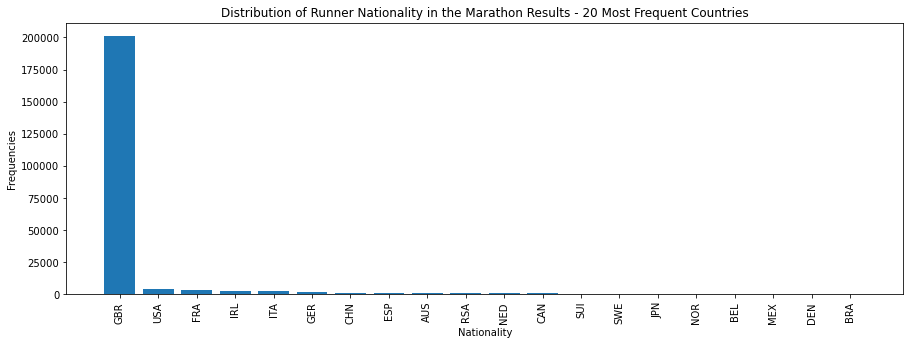

In [13]:
# Re-plot the nationality column with the top 20 nationalities by frequency

plt.figure(figsize=(15,5))
plt.bar(london_all_features_df["nationality"].value_counts().head(20).index, london_all_features_df["nationality"].value_counts().head(20).values)
plt.xlabel('Nationality')
plt.ylabel("Frequencies")
plt.title('Distribution of Runner Nationality in the Marathon Results - 20 Most Frequent Countries')
plt.xticks(rotation='vertical')
plt.show()

The majority of runners participating in the London Marathon are from the UK. 

#### Explore the distribution of finish time for the London marathon results

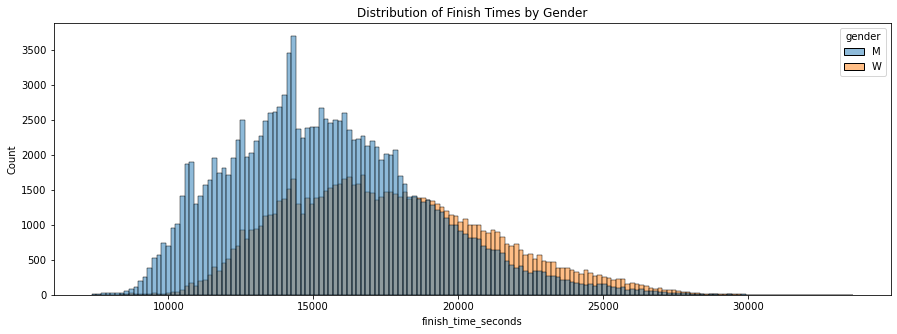

In [16]:
# Plot finish time by gender
plt.figure(figsize=(15,5))
finish_time_gender = london_all_features_df[['finish_time_seconds', 'gender']]
sns.histplot(x = 'finish_time_seconds', hue = 'gender', data=finish_time_gender)
plt.title('Distribution of Finish Times by Gender - London Marathon - 2014-2019')
plt.show()

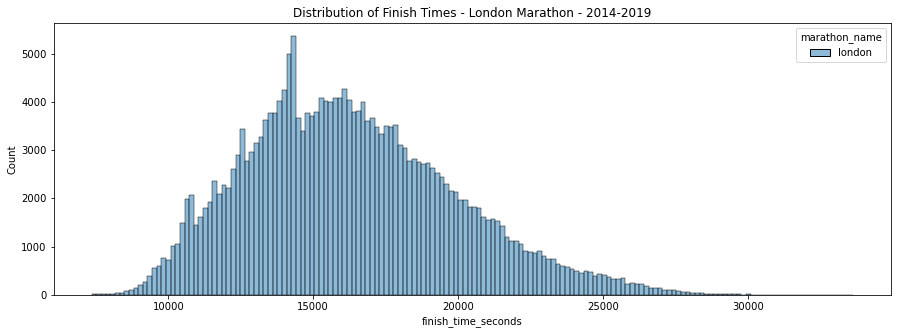

In [17]:
# Plot the distribution of finish times for the London Marathon 2014-2019
plt.figure(figsize = (15,5))
finish_time_marathon = london_all_features_df[['marathon_name', 'finish_time_seconds', 'year', 'gender']]
sns.histplot(x = 'finish_time_seconds', hue = 'marathon_name', data = finish_time_marathon)
plt.title('Distribution of Finish Times - London Marathon - 2014-2019')
plt.show()

### Data Transformation
- To Do List: 
    - Binarize the gender column
    - One Hot Encode the Nationality column
    - One Hot Encode the Nationality column
    - Drop columns that will not be used for modelling

#### Binarize the gender column

In [18]:
# Convert the gender column to binary 

london_all_features_df['gender'] = london_all_features_df['gender'].apply(lambda x: 0 if x == 'M' else 1)

# Confirm that the gender column has been converted to binary

london_all_features_df['gender'].describe()

count    231962.000000
mean          0.388555
std           0.487423
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: gender, dtype: float64

#### One Hot Encode the Nationality Column

In [19]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the subcategory column and transform
# It expects a 2D array, so we first convert the column into a DataFrame
runner_nationality = pd.DataFrame(london_all_features_df['nationality'])
encoded_runner_nationality = ohe.fit_transform(runner_nationality)
encoded_runner_nationality

<231962x160 sparse matrix of type '<class 'numpy.float64'>'
	with 231962 stored elements in Compressed Sparse Row format>

In [20]:
dense_array = encoded_runner_nationality.toarray()
dense_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
ohe.categories_

[array(['AFG', 'ALB', 'ALG', 'AND', 'ANG', 'ANT', 'ARG', 'ARM', 'ASA',
        'AUS', 'AUT', 'AZE', 'BAH', 'BAN', 'BAR', 'BDI', 'BEL', 'BEN',
        'BER', 'BIH', 'BIZ', 'BLR', 'BOL', 'BOT', 'BRA', 'BRU', 'BUL',
        'BUR', 'CAN', 'CAY', 'CGO', 'CHI', 'CHN', 'CIV', 'CMR', 'COL',
        'CPV', 'CRC', 'CRO', 'CYP', 'CZE', 'DEN', 'DMA', 'DOM', 'ECU',
        'EGY', 'ERI', 'ESA', 'ESP', 'EST', 'ETH', 'FIJ', 'FIN', 'FRA',
        'GAB', 'GBR', 'GEO', 'GEQ', 'GER', 'GHA', 'GRE', 'GRN', 'GUA',
        'GUI', 'HAI', 'HKG', 'HON', 'HUN', 'INA', 'IND', 'IRI', 'IRL',
        'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN',
        'KOR', 'KOS', 'KSA', 'KUW', 'LAT', 'LBN', 'LBR', 'LIE', 'LTU',
        'LUX', 'MAD', 'MAR', 'MAS', 'MAW', 'MDA', 'MDV', 'MEX', 'MGL',
        'MKD', 'MLT', 'MMR', 'MON', 'MRI', 'NAM', 'NCA', 'NED', 'NGR',
        'NIG', 'NOR', 'NPL', 'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL',
        'PLE', 'POL', 'POR', 'PRY', 'PUR', 'QAT', 'ROU', 'RSA', 'RUS',
      

In [22]:
# Put into a dataframe to get column names
encoded_runner_nationality_df = pd.DataFrame(dense_array, columns=ohe.categories_[0], dtype=int)
encoded_runner_nationality_df.index = runner_nationality.index

# Add original back in (just to check)
encoded_runner_nationality_df['runner_nationality'] = london_all_features_df['nationality']

# Show
encoded_runner_nationality_df.head()

,AFG,ALB,ALG,AND,ANG,ANT,ARG,ARM,ASA,AUS,...,UKR,URU,USA,UZB,Unknown,VEN,YEM,ZAM,ZIM,runner_nationality
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ERI
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GBR
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GBR
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GBR
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,GBR


In [23]:
# Check the dimension of the encoded_runner_nationality and the original marathon_df to ensure that they are the same

print(encoded_runner_nationality_df.shape, 
      london_all_features_df.shape)


(231962, 161) (231962, 21)


In [24]:
# Concatenate the encoded_runner_nationality_df with the marathon_df
london_all_features_df_ohe = pd.concat([london_all_features_df, encoded_runner_nationality_df], axis=1)

In [25]:
# Have a look at the concateated dataframe
london_all_features_df_ohe.head()

,marathon_name,year,place_overall,full_name,bib_number,age_class,elite_status,half_split_seconds,nationality,gender,...,UKR,URU,USA,UZB,Unknown,VEN,YEM,ZAM,ZIM,runner_nationality
0,london,2019,1,Weynay Ghebresilasie,1451,18-39,0,3904,ERI,0,...,0,0,0,0,0,0,0,0,0,ERI
1,london,2019,2,John Gilbert,1291,18-39,0,4080,GBR,0,...,0,0,0,0,0,0,0,0,0,GBR
2,london,2019,3,Ben Johnson,1246,18-39,0,4162,GBR,0,...,0,0,0,0,0,0,0,0,0,GBR
3,london,2019,4,Alex Milne,1456,18-39,0,4170,GBR,0,...,0,0,0,0,0,0,0,0,0,GBR
4,london,2019,5,Craig Ruddy,1362,18-39,0,4078,GBR,0,...,0,0,0,0,0,0,0,0,0,GBR


#### One Hot Encode the Marathon Name Column

In [26]:
# Instantiate the OneHotEncoder for converting marathon_name 
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the subcategory column and transform
# It expects a 2D array, so we first convert the column into a DataFrame

marathon_name = pd.DataFrame(london_all_features_df['marathon_name'])
encoded_marathon_name = ohe.fit_transform(marathon_name)
encoded_marathon_name

<231962x1 sparse matrix of type '<class 'numpy.float64'>'
	with 231962 stored elements in Compressed Sparse Row format>

In [27]:
dense_array = encoded_marathon_name.toarray()
dense_array

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [28]:
ohe.categories_

[array(['london'], dtype=object)]

In [29]:
# Put into a dataframe to get column names
encoded_marathon_name_df = pd.DataFrame(dense_array, columns=ohe.categories_[0], dtype=int)
encoded_marathon_name_df.index = marathon_name.index

# Add original back in (just to check)
encoded_marathon_name_df['marathon_name'] = london_all_features_df['marathon_name']

# Show
encoded_marathon_name_df.head()

,london,marathon_name
0,1,london
1,1,london
2,1,london
3,1,london
4,1,london


In [30]:
# Check the dimension of the encoded_marathon_name_df and the original marathon_df to ensure that they are the same

print(encoded_marathon_name_df.shape, 
      london_all_features_df.shape)


(231962, 2) (231962, 21)


In [31]:
# Concatenate the encoded_marathon_name_df with the marathon_df_ohe
london_all_features_df_ohe = pd.concat([london_all_features_df_ohe, encoded_marathon_name_df], axis=1)

In [32]:
# Have a look at the concateated dataframe
london_all_features_df_ohe.head()

,marathon_name,year,place_overall,full_name,bib_number,age_class,elite_status,half_split_seconds,nationality,gender,...,USA,UZB,Unknown,VEN,YEM,ZAM,ZIM,runner_nationality,london,marathon_name
0,london,2019,1,Weynay Ghebresilasie,1451,18-39,0,3904,ERI,0,...,0,0,0,0,0,0,0,ERI,1,london
1,london,2019,2,John Gilbert,1291,18-39,0,4080,GBR,0,...,0,0,0,0,0,0,0,GBR,1,london
2,london,2019,3,Ben Johnson,1246,18-39,0,4162,GBR,0,...,0,0,0,0,0,0,0,GBR,1,london
3,london,2019,4,Alex Milne,1456,18-39,0,4170,GBR,0,...,0,0,0,0,0,0,0,GBR,1,london
4,london,2019,5,Craig Ruddy,1362,18-39,0,4078,GBR,0,...,0,0,0,0,0,0,0,GBR,1,london


#### One Hot Encode the Age Class Column

In [33]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Fit the OneHotEncoder to the subcategory column and transform
# It expects a 2D array, so we first convert the column into a DataFrame
age_class = pd.DataFrame(london_all_features_df['age_class'])
encoded_age_class = ohe.fit_transform(age_class)
encoded_age_class

<231962x12 sparse matrix of type '<class 'numpy.float64'>'
	with 231962 stored elements in Compressed Sparse Row format>

In [34]:
dense_array = encoded_age_class.toarray()
dense_array

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [35]:
ohe.categories_

[array(['18-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69',
        '70+', '70-74', '75-79', '80-84', '85+'], dtype=object)]

In [36]:
# Put into a dataframe to get column names
encoded_age_class_df = pd.DataFrame(dense_array, columns=ohe.categories_[0], dtype=int)
encoded_age_class_df.index = age_class.index

# Add original back in (just to check)
encoded_age_class_df['age_class'] = london_all_features_df['age_class']

# Show
encoded_age_class_df.head()

,18-39,40-44,45-49,50-54,55-59,60-64,65-69,70+,70-74,75-79,80-84,85+,age_class
0,1,0,0,0,0,0,0,0,0,0,0,0,18-39
1,1,0,0,0,0,0,0,0,0,0,0,0,18-39
2,1,0,0,0,0,0,0,0,0,0,0,0,18-39
3,1,0,0,0,0,0,0,0,0,0,0,0,18-39
4,1,0,0,0,0,0,0,0,0,0,0,0,18-39


In [37]:
# Check the dimension of the encoded_runner_nationality and the original marathon_df to ensure that they are the same

print(encoded_age_class_df.shape, 
      london_all_features_df.shape)


(231962, 13) (231962, 21)


In [38]:
# Concatenate the encoded_runner_nationality_df with the marathon_df
london_all_features_df_ohe = pd.concat([london_all_features_df_ohe, encoded_age_class_df], axis=1)

In [39]:
# Have a look at the concateated dataframe
london_all_features_df_ohe.head()

,marathon_name,year,place_overall,full_name,bib_number,age_class,elite_status,half_split_seconds,nationality,gender,...,50-54,55-59,60-64,65-69,70+,70-74,75-79,80-84,85+,age_class
0,london,2019,1,Weynay Ghebresilasie,1451,18-39,0,3904,ERI,0,...,0,0,0,0,0,0,0,0,0,18-39
1,london,2019,2,John Gilbert,1291,18-39,0,4080,GBR,0,...,0,0,0,0,0,0,0,0,0,18-39
2,london,2019,3,Ben Johnson,1246,18-39,0,4162,GBR,0,...,0,0,0,0,0,0,0,0,0,18-39
3,london,2019,4,Alex Milne,1456,18-39,0,4170,GBR,0,...,0,0,0,0,0,0,0,0,0,18-39
4,london,2019,5,Craig Ruddy,1362,18-39,0,4078,GBR,0,...,0,0,0,0,0,0,0,0,0,18-39


#### Drop Columns that will not be used for modelling
Columns that will not be used for modelling: 
- marathon_name - was One Hot Encoded above
- full_name - not useful for modelling
- nationality and runner nationality have been One Hot Encoded
- place_overall - is a result of marathon finish time, so does not contribute to predicting finish time
- age_class- was One Hot Encoded above

In [40]:
london_all_features_df_ohe.drop(['marathon_name', 'full_name', 'nationality', 'runner_nationality', 'marathon_name', 'place_overall', 'age_class'], inplace = True, axis = 1)
london_all_features_df_ohe.head()


,year,bib_number,elite_status,half_split_seconds,gender,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,...,45-49,50-54,55-59,60-64,65-69,70+,70-74,75-79,80-84,85+
0,2019,1451,0,3904,0,8241,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,0
1,2019,1291,0,4080,0,8343,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,0
2,2019,1246,0,4162,0,8403,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,0
3,2019,1456,0,4170,0,8408,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,0
4,2019,1362,0,4078,0,8429,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,0


In [41]:
london_all_features_df_ohe.shape

(231962, 189)

The London Marathon had fewer nationalities as compared to the combined dataset previously explored (161 vs. 196 country codes. This resulted in fewer feature columns after transformation by One Hot Encoding (189 vs. 212) even though the age_class features were added. 

#### Set Up for Preliminary Modelling

In [42]:
# Set up independent and dependent variables

X_London = london_all_features_df_ohe.drop('finish_time_seconds', axis = 1)
y_London = london_all_features_df_ohe['finish_time_seconds']

In [43]:
# Import statsmodels

import statsmodels.api as sm

# Add constant to X
X_London_const_0 = sm.add_constant(X_London)

# Check it out 
X_London_const_0

,year,bib_number,elite_status,half_split_seconds,gender,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,...,45-49,50-54,55-59,60-64,65-69,70+,70-74,75-79,80-84,85+
0,2019,1451,0,3904,0,39.75,6.95,5.5,-10.3,137.4,...,0,0,0,0,0,0,0,0,0,0
1,2019,1291,0,4080,0,39.75,6.95,5.5,-10.3,137.4,...,0,0,0,0,0,0,0,0,0,0
2,2019,1246,0,4162,0,39.75,6.95,5.5,-10.3,137.4,...,0,0,0,0,0,0,0,0,0,0
3,2019,1456,0,4170,0,39.75,6.95,5.5,-10.3,137.4,...,0,0,0,0,0,0,0,0,0,0
4,2019,1362,0,4078,0,39.75,6.95,5.5,-10.3,137.4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231957,2017,125,1,4568,1,39.75,6.95,5.5,-10.3,137.4,...,0,0,0,0,0,0,0,0,0,0
231958,2017,131,1,4528,1,39.75,6.95,5.5,-10.3,137.4,...,0,0,0,0,0,0,0,0,0,0
231959,2017,132,1,4650,1,39.75,6.95,5.5,-10.3,137.4,...,0,0,0,0,0,0,0,0,0,0
231960,2017,117,1,4554,1,39.75,6.95,5.5,-10.3,137.4,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# First, divide data into remainder, and test sets
# Take 20% for the test set

X_London_remainder, X_London_test, y_London_remainder, y_London_test = \
    train_test_split(X_London_const_0, y_London, test_size = 0.2,
                     random_state=1)

In [45]:
# Now Split the remainder into two chunks
X_London_train, X_London_validation, y_London_train, y_London_validation = \
    train_test_split(X_London_remainder, y_London_remainder, test_size = 0.3,
                     random_state=1)

In [46]:
# Check the shapes
print(f'Shape of test set: {X_London_test.shape}')
print(f'Shape of validation set: {X_London_validation.shape}')
print(f'Shape of train set: {X_London_train.shape}')

# Remember 1 column is due to the constant

Shape of test set: (46393, 188)
Shape of validation set: (55671, 188)
Shape of train set: (129898, 188)


In [47]:
# Look at the summary statistics in the target column for each of the sets above:
print(f'The summary statistics for y_remainder: {y_London_remainder.describe()}')
print(f'The summary statistics for y_test: {y_London_test.describe()}')
print(f'The summary statistics for y_train: {y_London_train.describe()}')
print(f'The summary statistics for y_validation: {y_London_validation.describe()}')

The summary statistics for y_remainder: count    185569.000000
mean      16305.697924
std        3612.288707
min        7357.000000
25%       13693.000000
50%       15964.000000
75%       18617.000000
max       33611.000000
Name: finish_time_seconds, dtype: float64
The summary statistics for y_test: count    46393.000000
mean     16336.261548
std       3603.127656
min       7385.000000
25%      13703.000000
50%      15997.000000
75%      18637.000000
max      31264.000000
Name: finish_time_seconds, dtype: float64
The summary statistics for y_train: count    129898.000000
mean      16305.892138
std        3615.083584
min        7375.000000
25%       13693.000000
50%       15961.000000
75%       18625.000000
max       33611.000000
Name: finish_time_seconds, dtype: float64
The summary statistics for y_validation: count    55671.000000
mean     16305.244759
std       3605.791348
min       7357.000000
25%      13692.000000
50%      15968.000000
75%      18597.500000
max      32061.000000
Na

In [48]:
# Instantiate the linear regression model 
linreg_london_0 = sm.OLS(y_London, X_London_const_0)

# Fit the model (this returns a separate object with the parameters)
linreg_results_london_0 = linreg_london_0.fit()

# Display the results 
linreg_results_london_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     finish_time_seconds   R-squared:                       0.939
Model:                             OLS   Adj. R-squared:                  0.938
Method:                  Least Squares   F-statistic:                 1.999e+04
Date:                 Sun, 05 Dec 2021   Prob (F-statistic):               0.00
Time:                         11:53:02   Log-Likelihood:            -1.9058e+06
No. Observations:               231962   AIC:                         3.812e+06
Df Residuals:                   231784   BIC:                         3.814e+06
Df Model:                          177                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
year                  10.1047      1.206      8.377      0.000       7.741      12.469
bib_number            -0.0004      0.000     -3.650      0.000      -0.001      -0.000
elite_status          77.3742     67.230      1.151      0.250     -54.394     209.143
half_split_seconds     2.2986      0.001   1723.499      0.000       2.296       2.301
gender              -421.8148      4.120   -102.381      0.000    -429.890    -413.740
altitude_start       -16.5608      1.828     -9.059      0.000     -20.144     -12.978
altitude_finish       -2.8955      0.320     -9.059      0.000      -3.522      -2.269
max_slope             -2.2914      0.253     -9.059      0.000      -2.787      -1.796
min_slope              4.2912      0.474      9.059      0.000       3.363       5.220
elevation_gain       -57.2442      6.319     -9.059      0.000     -69.630     -44.859
elevation_loss        70.9095      7.828      9.059      0.000      55.567      86.252
course_turns         -23.3310      2.576     -9.059      0.000     -28.379     -18.283
temperature_min       40.8928      1.226     33.347      0.000      38.489      43.296
temperature_max       14.1218      2.004      7.048      0.000      10.195      18.049
precipitation      -1.167e-06   7.08e-07     -1.649      0.099   -2.55e-06     2.2e-07
AFG                  250.9071    283.667      0.885      0.376    -305.073     806.887
ALB                 1658.2303    399.573      4.150      0.000     875.077    2441.383
ALG                 -504.5386    630.281     -0.800      0.423   -1739.872     730.795
AND                 -308.9327    365.050     -0.846      0.397   -1024.420     406.555
ANG                  751.8034    446.383      1.684      0.092    -123.096    1626.702
ANT                 -278.9776    630.293     -0.443      0.658   -1514.336     956.381
ARG                 -182.8922     71.234     -2.567      0.010    -322.509     -43.275
ARM                 -107.6147    338.240     -0.318      0.750    -770.556     555.327
ASA                 -571.4841    890.643     -0.642      0.521   -2317.121    1174.152
AUS                   -0.9877     44.377     -0.022      0.982     -87.966      85.991
AUT                 -186.2369     75.449     -2.468      0.014    -334.114     -38.359
AZE                  627.7018    890.637      0.705      0.481   -1117.924    2373.328
BAH                  -55.1338    259.353     -0.213      0.832    -563.458     453.190
BAN                  808.0245    316.654      2.552      0.011     187.390    1428.659
BAR                  445.8922    446.403      0.999      0.318    -429.046    1320.830
BDI                  -15.9446    516.788     -0.031      0.975   -1028.835     996.946
BEL                 -236.7818     53.828     -4.399      0.000    -342.283    -131.281
BEN                 1112.38

The reduced dataset has resulted in huge improvement on the basic OLS model! The R-Squared returned is 0.939. 
The addition of the age classes, bib number, and half split time have resulted in a vastly improved model. It should be noted that bib numbers are generally assigned based on previous marathon performance (i.e. lower bib numbers are generally given to faster runners). 

In [50]:
linreg_london_0

In [51]:
# Retrieve the residuals
linreg_model_london_resids = linreg_results_london_0.resid

# Retrieve the fitted values
linreg_model_london_fittedvals = linreg_results_london_0.fittedvalues 

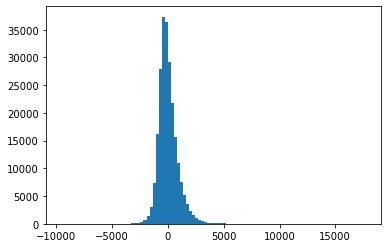

In [52]:
# Plot a histogram of the residuals
plt.figure()
plt.hist(linreg_model_london_resids, bins = 100)
plt.show()

The above histogram plot of the residuals is not a perfect normal distribution as it is slightly skewed to the right. 

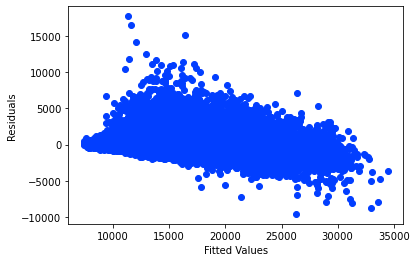

In [120]:
# Scatter plot of fitted values vs. residuals
plt.figure()
plt.scatter(linreg_model_london_fittedvals, linreg_model_london_resids)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

The plot of the fitted values vs. the residuals does not appear totally random, although it does appear more random than the initial model for the combined marathon dataset. This lack of randomness indicates that the last assumption of the linear model (homoscedasticity) is being violated. While the R Squared value was high 0.939, as the model violated the assumption of homoscedasticity and due to the fact that some of the independent variables are highly correlated, this model is not a good fit for the data as it presently is. 

#### Fit the same linear model using scikit learn

In [53]:
# Create linear regression object
london_regr_0 = linear_model.LinearRegression()

# Train the model using the training sets
london_regr_0.fit(X_London_remainder, y_London_remainder)

# Make predictions using the testing set
london_y_pred = london_regr_0.predict(X_London_test)

# Use this to look at the coefficients if desired
# print("Coefficients: \n", london_regr_0.coef_)

# The mean squared error
print("Mean absolute error: %.2f" % mean_absolute_error(y_London_test, london_y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_London_test, london_y_pred))

# Score the model 
london_regr_0.score(X_London_test, y_London_test)


Mean absolute error: 647.76
Coefficient of determination: 0.94


0.9391862233593875

The R-Squared value from SKlearn and the OLS model were identical (0.939). The mean absolute error returned by SKlearn of 647.76 seconds (an error of 10.8 minutes) is a huge improvement over previous models and is now the benchmark from which to try and improve the model.  

#### Try Adding L2 Regularization (Ridge Regression)
L2 Regularization encourages coefficients to be smaller. The following will only be done on the train/test split to get a sense of the effect of L2 Regularization. Hyperparameter optimization will be completed later. 

In [54]:
# Instantiate, fit, and score a Ridge Regression model
london_ridge_reg_0 = Ridge()
london_ridge_reg_0.fit(X_London_remainder, y_London_remainder)

print(f"Linear Regression (None) for train data: {london_regr_0.score(X_London_test, y_London_test)}")
print(f"R^2 of the Ridge Regression (L2) for train data: {london_ridge_reg_0.score(X_London_test, y_London_test)}")


Linear Regression (None) for train data: 0.9391862233593875
R^2 of the Ridge Regression (L2) for train data: 0.9391979954257376


It appears that the default Ridge Regression (loss function = the linear least squares function) with alpha of 1.0 slightly improved the performance of the model over the basic sklearn linear model.  

In [55]:
# Instantiate, fit and score a Lasso Regression model

london_lasso_reg_0 = Lasso()
london_lasso_reg_0.fit(X_London_remainder, y_London_remainder)

# Evaluate Linear Regression: 
print(f"Linear Regression (None) for test data: {london_regr_0.score(X_London_test, y_London_test)}")

# Make predictions for the Linear Regression using the testing set
london_regr_0_y_pred = london_regr_0.predict(X_London_test)

# Get mean absolute error for Linear Regression:
print(f"Mean Absolute Error Linear Regression for test data: {mean_absolute_error(y_London_test, london_regr_0_y_pred)}")

# Evaluate Ridge Regression: 
print(f"R^2 of the Ridge Regression (L2) for test data: {london_ridge_reg_0.score(X_London_test, y_London_test)}")

# Make predictions for Ridge Regression using the testing set
london_ridge_reg_0_y_pred = london_ridge_reg_0.predict(X_London_test)

# Get mean absolute error for Ridge Regression: 
print(f"Mean Absolute Error Ridge Regression for test data: {mean_absolute_error(y_London_test, london_ridge_reg_0_y_pred)}")

# Evaluate Lasso Regression: 
print(f"R^2 of the Lasso Regression (L1) for test data: {london_lasso_reg_0.score(X_London_test, y_London_test)}")

# Make predictions for Lasso Regression using the testing set
london_lasso_reg_0_y_pred = london_lasso_reg_0.predict(X_London_test)

# Get mean absolute error for Lasso Regression: 
print(f"Mean Absolute Error Lasso Regression for test data: {mean_absolute_error(y_London_test, london_lasso_reg_0_y_pred)}")

Linear Regression (None) for test data: 0.9391862233593875
Mean Absolute Error Linear Regression for test data: 647.7576580112767
R^2 of the Ridge Regression (L2) for test data: 0.9391979954257376
Mean Absolute Error Ridge Regression for test data: 647.7197274947404
R^2 of the Lasso Regression (L1) for test data: 0.9391610592936547
Mean Absolute Error Lasso Regression for test data: 647.9769041707353


It appears that there was no improvement when using the Lasso Regression over Ridge Regression. The very minor improvement with Ridge Regression over the basic Linear Regression model was negligible when looking at both R Squared and Mean Absolute Error values.

#### Try PCR (Standard Scaler) and PLS

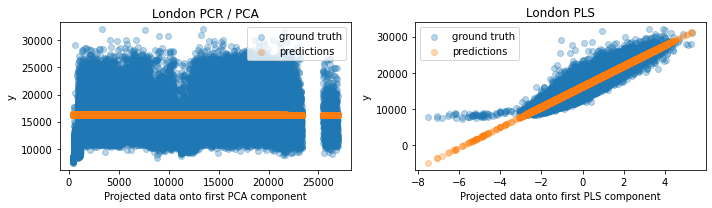

In [56]:
# Attempt Principal Component Regression and Partial Least Squares Regression

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_London_train, y_London_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_London_train, y_London_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_London_validation), y_London_validation, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_London_validation), pcr.predict(X_London_validation), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="London PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_London_validation), y_London_validation, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_London_validation), pls.predict(X_London_validation), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="London PLS")
axes[1].legend()
plt.tight_layout()
plt.show()

In [57]:
print(f"London PCR r-squared {pcr.score(X_London_test, y_London_test):.3f}")
print(f"London PLS r-squared {pls.score(X_London_test, y_London_test):.3f}")

London PCR r-squared 0.000
London PLS r-squared 0.818


The r-squared for PCR (Standard Scaler doesnt' seem correct, try without adding the Standard Scaler step)

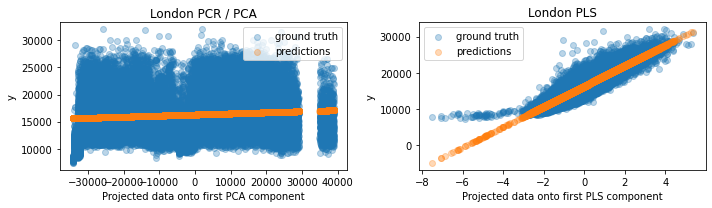

In [58]:
# Re-run the PCR and PLS from above, without using a standard scaler for PCR

pcr = make_pipeline(PCA(n_components=1), LinearRegression())
pcr.fit(X_London_train, y_London_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_London_train, y_London_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_London_validation), y_London_validation, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_London_validation), pcr.predict(X_London_validation), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="London PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_London_validation), y_London_validation, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_London_validation), pls.predict(X_London_validation), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="London PLS")
axes[1].legend()
plt.tight_layout()
plt.show()

In [59]:
print(f"London PCR (Unscaled) r-squared {pcr.score(X_London_test, y_London_test):.3f}")
print(f"London PLS r-squared {pls.score(X_London_test, y_London_test):.3f}")

London PCR (Unscaled) r-squared 0.008
London PLS r-squared 0.818


Scaling vs. not scaling using a Standard Scaler did not seem to have any effect on Principal component regression. The Partial Least Squares Regression showed improvement vs. PCR, but did not perform as well as the Ridge Regression model above.  

#### Investigate Decision Tree, Random Forest, AdaBoost, Gradient Boost, and XGBoost Models

In [62]:
# Instantiate, fit and score Decision Tree, Random Forest, AdaBoost, and Gradient Boost Models

london_0_DT_model = DecisionTreeRegressor()
london_0_RF_model = RandomForestRegressor()
london_0_AB_model = AdaBoostRegressor()
london_0_grad_boost_model = GradientBoostingRegressor()

london_0_DT_model.fit(X_London_train, y_London_train)
london_0_RF_model.fit(X_London_train, y_London_train)
london_0_AB_model.fit(X_London_train, y_London_train)
london_0_grad_boost_model.fit(X_London_train, y_London_train)

print("Test Set Scores:")
print(f"Random Forest score: {london_0_RF_model.score(X_London_validation,y_London_validation)}")
print(f"Decision Tree score: {london_0_DT_model.score(X_London_validation,y_London_validation)}")
print(f"AdaBoost score: {london_0_AB_model.score(X_London_validation,y_London_validation)}")
print(f"Gradient Boost score: {london_0_grad_boost_model.score(X_London_validation,y_London_validation)}")

Test Set Scores:
Random Forest score: 0.9331766612189837
Decision Tree score: 0.8783577119841361
AdaBoost score: 0.7350227895175447
Gradient Boost score: 0.9404241358689064


The default Gradient Boost model showed improved performance (based on R-Squared values) over the Random Forest, Decision Tree and AdaBoost models. Next, I will try an XGBoost model to see if an improvement can be gained.

In [61]:
# Instantiate, fit and score a default XGBoost regression model
london_XGB_model_0 = XGBRegressor()
london_XGB_model_0.fit(X_London_train, y_London_train)
print(f"XG Boost score: {london_XGB_model_0.score(X_London_validation, y_London_validation)}")

XG Boost score: 0.9403149096508094


### Explore an XGBoost model

#### Try to Optimize XG Boost

#### Hyperparameters that can potentially be optimized for XGBoost
Descriptions of the hyperparameters are from the XGBoost documentation:
https://xgboost.readthedocs.io/en/latest/parameter.html

After some research, these appear to be the hyperparameters that are most commonly optimized with XGBoost models:

- eta/learning_rate:
    - Step size shrinkage used to prevent overfitting.
    - The range is 0-1. 
    - Default is set to 0.3.

- max_depth: 
    - Determines how deeply each tree is allowed to grow during any boosting round. A higher number is likely to lead to overfitting.
    - The range is 0 to infinity. 
    - Default is set to 6
    
- subsample: 
    - Percentage of training data subsampled before growing trees. Lower values can lead to underfitting.
    - The range is 0 to 1.
    - The default is 1. 
    
- colsample_bytree: 
    - percentage of features used per tree. Higher values can lead to overfitting.
    - The range is 0 to 1.
    - The default is 1. 
    
- n_estimators/num_boost_rounds: was explored above

- lambda: 
    - L2 regularization term on weights. Increasing this value will make model more conservative.
    - The default is set to 1.
    
- alpha:
    - L1 regularization term on weights. Increasing this value will make model more conservative.
    - The default is set to 0. 


NOTE: This grid search took 6+ hours to run. 

In [138]:
%%time

london_XGB_model_1 = XGBRegressor()

learning_rate_list = [0.1, 0.2, 0.5, 1.0] # Try 4 learning rates [0.1, 0.2, 0.5, 1.0]
n_estimators_list = list(range(1, 100, 5))     # Try estimators from 1 to 100, in jumps of 5

param_grid = {'n_estimators': n_estimators_list, 
              'learning_rate': learning_rate_list}

# Use default 5-fold Cross Validation
london_grid_xgb = GridSearchCV(london_XGB_model_1, param_grid=param_grid, verbose=1, n_jobs=-1)
london_grid_xgb.fit(X_London_train, y_London_train); # semicolon to prevent the gridsearch from printing itself
                                # after fitting

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 149.9min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 361.1min finished


CPU times: user 4min 1s, sys: 10.7 s, total: 4min 12s
Wall time: 6h 5min 4s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
      

In [140]:
# Retrieve the score from the best model identified above
london_grid_xgb.score(X_London_validation, y_London_validation)

0.9406729207261767

In [148]:
# Retreive the parameters of the best model model fitted above
london_grid_xgb.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=86, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [141]:
# Save the model identified above. 

joblib.dump(london_grid_xgb.best_estimator_, 'london_grid_xgb.pkl')

['london_grid_xgb.pkl']

In [ ]:
# Create data frame so we can easily create visual

london_grid_xgb_results_df = pd.DataFrame({
    "n_estimators": london_grid_xgb.cv_results_["param_n_estimators"],
    'lr': london_grid_xgb.cv_results_["param_learning_rate"],
    'mean_score': london_grid_xgb.cv_results_["mean_test_score"],
})
london_grid_xgb_results_df


In [ ]:
# Plot the XGBoost Performance (R^2) with Various Estimator Numbers and Learning Rates

plt.figure(figsize=(15,7))

for lr in london_grid_xgb_results_df['lr'].unique():
    
    lr_df = london_grid_xgb_results_df[london_grid_xgb_results_df['lr'] == lr]
    n_est = lr_df['n_estimators']
    accuracy_scores = 100*lr_df['mean_score']
    
    plt.plot(n_est, accuracy_scores, label=f"lr={lr}, max accuracy={round(np.max(accuracy_scores), 2)}%")

plt.title("XGBoost Pefromance with Various Estimator Numbers and Learning Rates", size=20)
plt.ylabel("Accuracy (%)", size=16)
plt.xlabel("Estimator Number", size=16)
plt.legend()
plt.show()

#### Convert the data to DMatrix objects
The DMatrix data format was specifically created for XGBoost to allow the model operate as efficiently as possible.   

See the XGBoost documentation for more information: https://xgboost.readthedocs.io/en/latest/python/python_intro.html

In [63]:
# Convert the train, validation and test sets to DMatrix objects

remainder_dmatrix = xgb.DMatrix(data = X_London_remainder, label = y_London_remainder)
train_dmatrix = xgb.DMatrix(data = X_London_train, label = y_London_train)
validation_dmatrix = xgb.DMatrix(data = X_London_validation, label = y_London_validation)
test_dmatrix = xgb.DMatrix(data = X_London_test, label = y_London_test)

#### Try out different learners: "gbtree" (default) and "gblinear"

In [64]:
# Set base learner as "booster=gbtree" (default)
# XGBoost uses regression with squared loss as the default learning objective, this will be used for the duration of working with this model

# Use a parameter dictionary to specify base learner, and the learning objective "reg:squarederror"
param_gbt = {"booster":"gbtree", "objective":"reg:squarederror"}

# num_boost_round is equivalent to the number of estimators (i.e. the number of trees built)
# this parameter will be set to 10, but is a candidate for optimization

london_xgb_gbtree_0 = xgb.train(params = param_gbt, dtrain = train_dmatrix, num_boost_round = 10)
london_pred_gbtree = london_xgb_gbtree_0.predict(validation_dmatrix)
  
# Mean Absolute Error
mae = mean_absolute_error(y_London_validation, london_pred_gbtree)
print("Mean Absolute Error : % f" %(mae))

Mean Absolute Error :  686.562550


This mean absolute error of 686.56 seconds corresponds to an error of just over 11.5 minutes. While this is the benchmark for the default model attempted with the default tree booster, a 10+ minute window of error is not particularly helpful to a marathon runer. Attempts to improve the model by optimizing hyperparameters will be made below.

In [65]:
# Set base learner as "booster":"gblinear"
# Parameter dictionary specifying base learner
param_gbl= {"booster":"gblinear", "objective":"reg:squarederror"}
  
london_xgb_gblinear_0 = xgb.train(params = param_gbl, dtrain = train_dmatrix, num_boost_round = 10)
london_pred_gblinear = london_xgb_gblinear_0.predict(validation_dmatrix)
  
# Mean Absolute Error
mae = mean_absolute_error(y_London_validation, london_pred_gblinear)
print("Mean Absolute Error : % f" %(mae))

Mean Absolute Error :  2139.037580


This mean absolute error of 2140.2 seconds corresponds to an error in finish time of just over 35 minutes. This level of error in the context of marathon finish times is not helpful for runners. Further exploration of the XGBoost model will use the default learner "gbtree". 

#### Explore the initial "gbtree" model above

In [66]:
# Use a k-fold Cross Validation Using XGBoost to explore increasing the number of boost rounds (trees built)
# This model was run using the train dmatrix subset of the data
# The learning rate was set to 0.1 to match the optimal model identified in the grid search above
# Increase this to 100, but set early stopping parameter to 10
# This will take effect in the event that the model stops improving over a number of consecutive rounds

params = {"booster":"gbtree", "objective":"reg:squarederror", "learning_rate":0.1}

london_xgb_gbtree_0_cv_results = xgb.cv(dtrain = train_dmatrix, params=params, nfold = 5,
                    num_boost_round = 100, early_stopping_rounds = 15, metrics="mae", as_pandas=True, seed=123)

In [72]:
# By including the as_pandas = True above, dumps the Mean absolute error output for each of the rounds into a dataframe
# This allows for easy visualization 
# Print the data frame
print(london_xgb_gbtree_0_cv_results.head())
print(london_xgb_gbtree_0_cv_results.tail())

   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0    14675.380664       6.478947   14675.392969     25.482410
1    13208.341211       5.851980   13208.327734     22.561303
2    11887.969727       5.219178   11887.993164     19.982501
3    10699.666992       4.666203   10699.665820     17.559374
4     9630.105273       4.231901    9630.150976     15.306135
    train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
42      617.379077       0.492467     623.828699      2.428198
43      616.277918       0.521925     622.901648      2.396007
44      615.569336       0.542783     622.351892      2.357157
45      615.169141       0.549829     622.114404      2.329671
46      614.995715       0.545531     622.107275      2.309223


The train and test mean absolute errors are decreasing with every boosting round. 

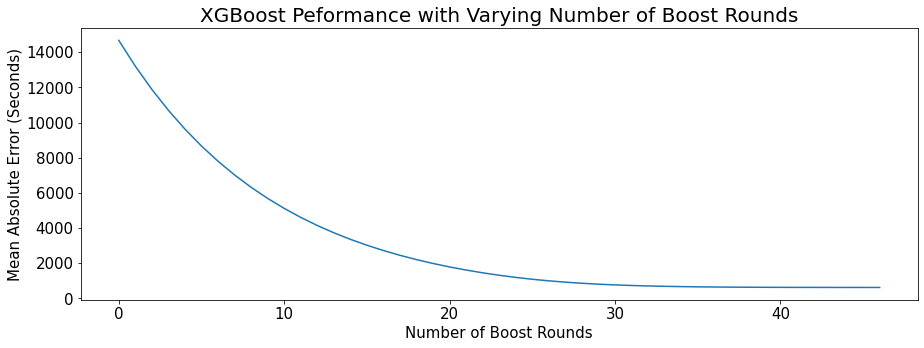

In [140]:
# Plot the mae by the number of boost rounds
plt.figure(figsize=(15,5))
    
plt.plot(london_xgb_gbtree_0_cv_results.index,london_xgb_gbtree_0_cv_results["test-mae-mean"])

plt.title("XGBoost Peformance with Varying Number of Boost Rounds", size=20)
plt.ylabel("Mean Absolute Error (Seconds)", size=15)
plt.xlabel("Number of Boost Rounds", size=15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.savefig('XGBoost Performance by Boost Rounds.png', dpi=300)
plt.show()

In [71]:
# Look at the Mean Absolute Error 
print((london_xgb_gbtree_0_cv_results["test-mae-mean"]).tail(1))

46    622.107275
Name: test-mae-mean, dtype: float64


By increasing the number of trees/boosting rounds to 46, the model was able to decrease the mean absolute error to 622.1 seconds (just over 10 minutes). An error rate of 10+ minutes is not ideal for an elite competitive athlete, but for a casual marathon runner, an estimated time difference of 10 minutes may be helpful in predicting a marathon finish time. 


#### Set up and run the final model

In [73]:
# Re-train the model on the remainder set and test on the yet unseen test set 
# Use optimized hyperparameters identified above:
# learning_rate = 0.1 and n_estimators/num_boost_round = 46

params = {"booster":"gbtree", "objective":"reg:squarederror", "learning_rate":0.1}

london_xgb_gbtree_final = xgb.train(dtrain = remainder_dmatrix, params=params, num_boost_round = 46)
london_pred_gbtree_final = london_xgb_gbtree_final.predict(test_dmatrix)
  
# Mean Absolute Error
mae = mean_absolute_error(y_London_test, london_pred_gbtree_final)
print("Mean Absolute Error : % f" %(mae))

Mean Absolute Error :  616.473129


Re-training the model on the remainder set and testing on the yet unseen testing set resulted in a decreases Mean Absolute Error of 616.5 seconds. 

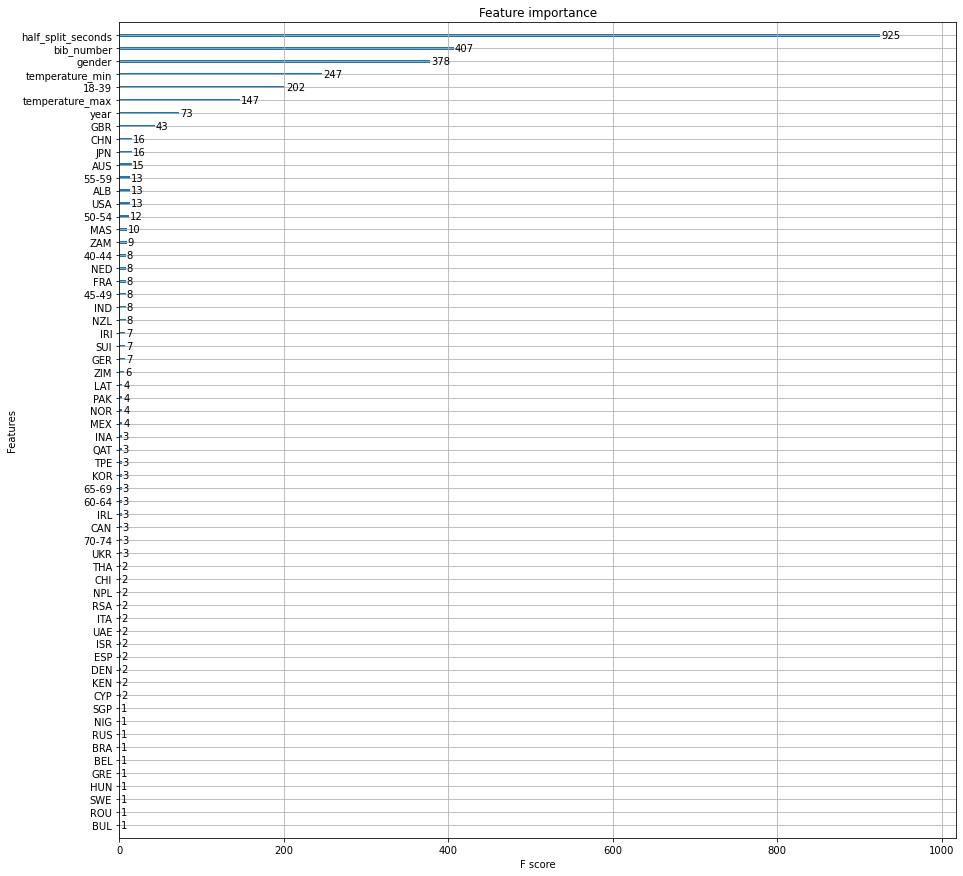

In [100]:
# Look at the importance of each feature
# This provides a full description of the factors being considered in calculating feature importance (F Score): 
# https://github.com/dmlc/xgboost/blob/b4f952b/python-package/xgboost/core.py#L1639-L1661
# NOTE: feature importance is only defined when decision tree is chosen as the base learner ("booster=gbtree"), and
# not for linear base learners (eg. "booster=gblinear")

# Plot the top features by importance
# plt.figure(figsize = (15,10))
plt.rcParams['figure.figsize'] = [15,15]
plt.rcParams['font.size'] = '10'
xgb.plot_importance(london_xgb_gbtree_final)
plt.show()

In [101]:
# Retrieve the average finish time and half split time for the London Marathon
print(london_all_features_df_ohe['finish_time_seconds'].mean())
print(london_all_features_df_ohe['half_split_seconds'].mean())

16311.810727619179
7565.218126244816


It's not surprising that the top two predictors were half-split time in seconds followed by bib number. For the most part, a runner's finish time will be roughly double their half split time. The average finish time in seconds for the London Marathon was 16,311.8 and the average half_split was 7,565.2. Bib numbers are generally assigned based on starting placement with elite (fast) runners generally being assigned smaller bib numbers, and slower runners generally being assigned higher bib numbers. Bib number is in effect an indirect indicator of prior performance. In an attempt to try to further improve the model, I will look at removing outliers within the dataset. 

#### Look at outliers in the finish time seconds

First, visualize outliers present in the finish_time_seconds column. 


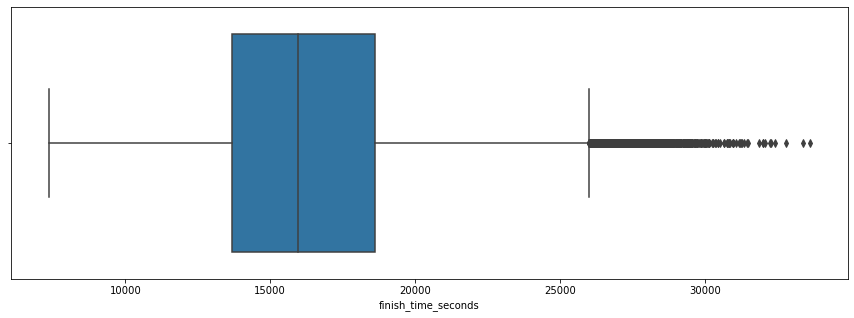

In [103]:
# Create a box plot of the finish_time_seconds feature to visualize any outliers present

plt.figure(figsize = (15,5))
sns.boxplot(x = london_all_features_df_ohe['finish_time_seconds'])
plt.show()

There appear to be a number of outliers in the finish time seconds column. 

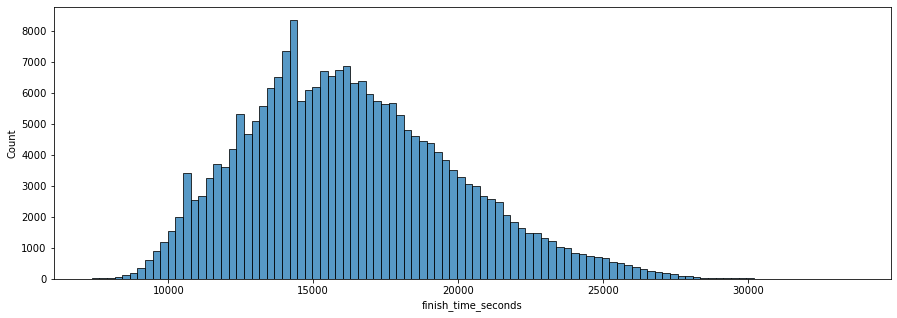

In [104]:
# Look at a histogram of the finish_time_seconds_feature

plt.figure(figsize = (15,5))
sns.histplot(london_all_features_df_ohe['finish_time_seconds'], bins = 100)
plt.show()

For identifying and dropping outliers, I followed this guide: https://hersanyagci.medium.com/detecting-and-handling-outliers-with-pandas-7adbfcd5cad8

This will use Tukey's rule/IQR (interquartile range) rule to detect outliers:
Steps: 
- 1 - Calculate the IQR of data: (Q3-Q1)
- 2 - Calculate the Lower Boundary: Q1–1.5 * IQR
- 3 - Calculate the Upper Boundary: Q3 + 1.5 * IQR
      

In [105]:
london_all_features_df_ohe[['finish_time_seconds']].describe()

,finish_time_seconds
count,231962.000000
mean,16311.810728
std,3610.471273
min,7357.000000
25%,13695.000000
50%,15971.000000
75%,18621.000000
max,33611.000000


In [106]:
# Calculate Q1, Q3 and IQR

Q1 = london_all_features_df_ohe['finish_time_seconds'].quantile(0.25)
print(f'Q1: {Q1}')

Q3 = london_all_features_df_ohe['finish_time_seconds'].quantile(0.75)
print(f'Q3: {Q3}')

IQR = Q3-Q1
print(f'IQR: {IQR}')

# Calculate the Lower and Upper Limits

lower_limit = Q1 - 1.5 * IQR
print(f'lower_limit: {lower_limit}')

upper_limit = Q3 + 1.5 * IQR
print(f'upper_limit: {upper_limit}')

Q1: 13695.0
Q3: 18621.0
IQR: 4926.0
lower_limit: 6306.0
upper_limit: 26010.0


#### Apply these limits to the data and see how many records are impacted

In [107]:
outliers_lower = (london_all_features_df_ohe['finish_time_seconds'] < lower_limit)

outliers_upper = (london_all_features_df_ohe['finish_time_seconds'] > upper_limit)

In [108]:
london_all_features_df_ohe[(outliers_lower|outliers_upper)]

,year,bib_number,elite_status,half_split_seconds,gender,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,...,45-49,50-54,55-59,60-64,65-69,70+,70-74,75-79,80-84,85+
24569,2019,27705,0,12188,0,26011,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,0
24570,2019,68964,0,12746,0,26028,39.75,6.95,5.5,-10.3,...,0,0,1,0,0,0,0,0,0,0
24571,2019,10042,0,12000,0,26032,39.75,6.95,5.5,-10.3,...,1,0,0,0,0,0,0,0,0,0
24572,2019,36571,0,12299,0,26036,39.75,6.95,5.5,-10.3,...,1,0,0,0,0,0,0,0,0,0
24573,2019,3742,0,11206,0,26047,39.75,6.95,5.5,-10.3,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231900,2017,1989,0,12201,1,31082,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,0
231901,2017,41041,0,13281,1,31337,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,0
231902,2017,61995,0,13133,1,31487,39.75,6.95,5.5,-10.3,...,1,0,0,0,0,0,0,0,0,0
231903,2017,36065,0,13466,1,31993,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,0


There are 1989 outliers. All these outliers were from the upper bound (none were from the lower bound). As there are only 1989 records, these will be dropped to see if any improvement can be gained. 

In [109]:
# Original number of rows
london_all_features_df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231962 entries, 0 to 231961
Columns: 189 entries, year to 85+
dtypes: float64(9), int64(180)
memory usage: 334.5 MB


In [110]:
# Create a new dataframe with the outliers dropped
london_all_features_no_outliers = london_all_features_df_ohe[~(outliers_lower|outliers_upper)]
london_all_features_no_outliers


,year,bib_number,elite_status,half_split_seconds,gender,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,...,45-49,50-54,55-59,60-64,65-69,70+,70-74,75-79,80-84,85+
0,2019,1451,0,3904,0,8241,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,0
1,2019,1291,0,4080,0,8343,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,0
2,2019,1246,0,4162,0,8403,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,0
3,2019,1456,0,4170,0,8408,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,0
4,2019,1362,0,4078,0,8429,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231957,2017,125,1,4568,1,9491,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,0
231958,2017,131,1,4528,1,9567,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,0
231959,2017,132,1,4650,1,9758,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,0
231960,2017,117,1,4554,1,9811,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,0


The 1989 columns were removed from the original dataset. Have a look at the distributions again and then run the model on this data. 

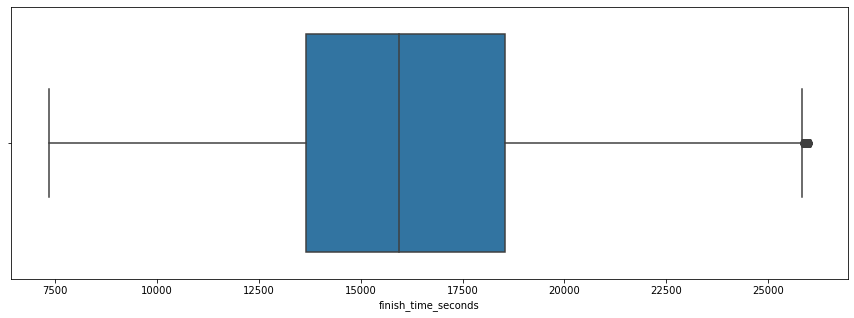

In [111]:
# Create a box plot of the finish_time_seconds feature to visualize any outliers present

plt.figure(figsize = (15,5))
sns.boxplot(x = london_all_features_no_outliers['finish_time_seconds'])
plt.show()

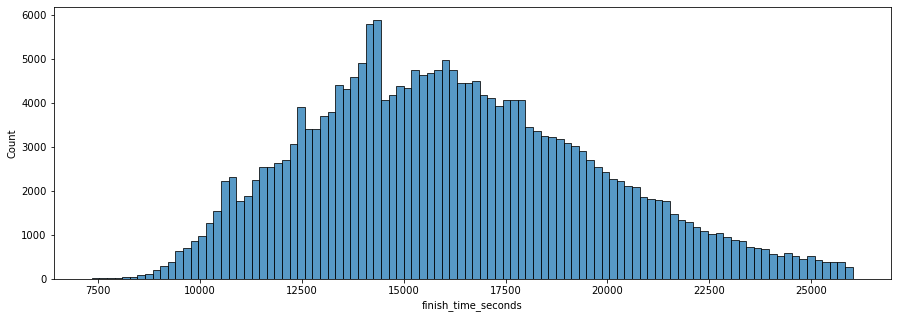

In [112]:
# Look at a histogram of the finish_time_seconds_feature

plt.figure(figsize = (15,5))
sns.histplot(london_all_features_no_outliers['finish_time_seconds'], bins = 100)
plt.show()

The majority of the outliers identified earlier have been removed, but some do remain. Depending on the outcome of modelling, perhaps using a factor of 2 or 2.5 (rather than 1.5) to calculate IQR could be investigated. 

#### Set up for preliminary modelling with outliers removed


In [113]:
# Set up independent and dependent variables

X_London_no_outliers = london_all_features_no_outliers.drop('finish_time_seconds', axis = 1)
y_London_no_outliers = london_all_features_no_outliers['finish_time_seconds']

In [114]:
# First, divide data into remainder, and test sets
# Take 20% for the test set

X_London_no_outliers_remainder, X_London_no_outliers_test, y_London_no_outliers_remainder, y_London_no_outliers_test = \
    train_test_split(X_London_no_outliers, y_London_no_outliers, test_size = 0.2,
                     random_state=1)

In [115]:
# Now Split the remainder into two chunks
X_London_no_outliers_train, X_London_no_outliers_validation, y_London_no_outliers_train, y_London_no_outliers_validation = \
    train_test_split(X_London_no_outliers_remainder, y_London_no_outliers_remainder, test_size = 0.3,
                     random_state=1)

In [116]:
# Check the shapes
print(f'Shape of test set: {X_London_no_outliers_test.shape}')
print(f'Shape of validation set: {X_London_no_outliers_validation.shape}')
print(f'Shape of train set: {X_London_no_outliers_train.shape}')


Shape of test set: (45995, 188)
Shape of validation set: (55194, 188)
Shape of train set: (128784, 188)


In [117]:
# Look at the summary statistics in the target column for each of the sets above:
print(f'The summary statistics for y_remainder: {y_London_no_outliers_remainder.describe()}')
print(f'The summary statistics for y_test: {y_London_no_outliers_test.describe()}')
print(f'The summary statistics for y_train: {y_London_no_outliers_train.describe()}')
print(f'The summary statistics for y_validation: {y_London_no_outliers_validation.describe()}')


The summary statistics for y_remainder: count    183978.000000
mean      16215.144713
std        3480.755152
min        7357.000000
25%       13674.000000
50%       15933.000000
75%       18532.000000
max       26010.000000
Name: finish_time_seconds, dtype: float64
The summary statistics for y_test: count    45995.000000
mean     16230.529144
std       3481.790250
min       7396.000000
25%      13671.000000
50%      15940.000000
75%      18552.000000
max      26008.000000
Name: finish_time_seconds, dtype: float64
The summary statistics for y_train: count    128784.000000
mean      16213.885886
std        3475.330791
min        7357.000000
25%       13688.000000
50%       15935.000000
75%       18517.000000
max       26010.000000
Name: finish_time_seconds, dtype: float64
The summary statistics for y_validation: count    55194.000000
mean     16218.081929
std       3493.408829
min       7469.000000
25%      13641.000000
50%      15927.000000
75%      18569.750000
max      26005.000000
Na

In [118]:
# Create linear regression object
london_no_outliers_regr_0 = linear_model.LinearRegression()

# Train the model using the training sets
london_no_outliers_regr_0.fit(X_London_no_outliers_remainder, y_London_no_outliers_remainder)

# Make predictions using the testing set
london_no_outliers_y_pred = london_no_outliers_regr_0.predict(X_London_no_outliers_test)

# The Mean Absolute Error
print("Mean absolute error: %.2f" % mean_absolute_error(y_London_no_outliers_test, london_no_outliers_y_pred))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_London_no_outliers_test, london_no_outliers_y_pred))

# Score the model 
london_regr_0.score(X_London_no_outliers_test, y_London_no_outliers_test)

Mean absolute error: 645.67
Coefficient of determination: 0.94


0.9364011897210205

Removing the outliers resulted in a similar mean absolute error to model above that included the outliers (645.57 vs. 647.76). A default XGBoost model will be run below to see if any improvement was obtained. 

#### Try an XGBoost

In [119]:
# XGBoost with outliers removed
london_no_outliersXGB_model_0 = XGBRegressor()
london_no_outliersXGB_model_0.fit(X_London_no_outliers_train, y_London_no_outliers_train)
print(f"XG Boost score: {london_no_outliersXGB_model_0.score(X_London_no_outliers_validation, y_London_no_outliers_validation)}")

XG Boost score: 0.9394464331156133


The XGBoost scores with and without outliers are very similar. 

In [121]:
# Convert the train, validation and test sets to DMatrix objects
remainder_no_outliers_dmatrix = xgb.DMatrix(data = X_London_no_outliers_remainder, label = y_London_no_outliers_remainder)
train_no_outliers_dmatrix = xgb.DMatrix(data = X_London_no_outliers_train, label = y_London_no_outliers_train)
validation_no_outliers_dmatrix = xgb.DMatrix(data = X_London_no_outliers_validation, label = y_London_no_outliers_validation)
test_no_outliers_dmatrix = xgb.DMatrix(data = X_London_no_outliers_test, label = y_London_no_outliers_test)


In [122]:
# Use a k-fold Cross Validation Using XGBoost to explore increasing the number of boost rounds (trees built)
# Set the learning rate to 0.1
# Increase this to 100, but set early stopping parameter to 10
# This will take effect in the event that the model stops improving over a number of consecutive rounds

params = {"booster":"gbtree", "objective":"reg:squarederror", "learning_rate":0.1}

london_xgb_gbtree_no_outliers_cv_results = xgb.cv(dtrain = train_no_outliers_dmatrix, params=params, nfold = 5,
                    num_boost_round = 100, early_stopping_rounds = 15, metrics="mae", as_pandas=True, seed=123)

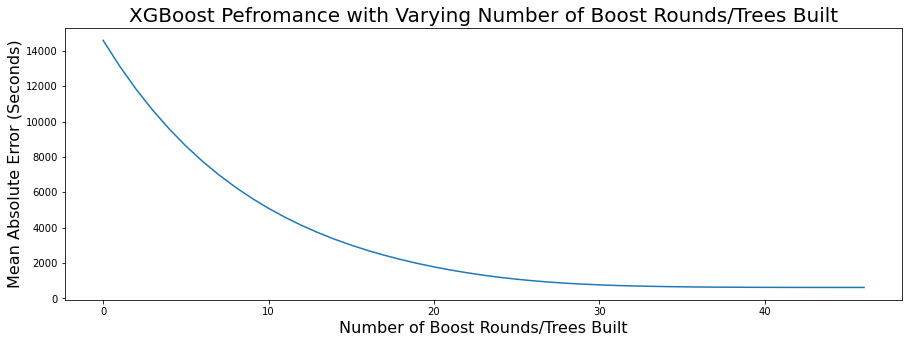

In [124]:
# Plot the mae by the number of boost rounds
plt.figure(figsize=(15,5))
    
plt.plot(london_xgb_gbtree_no_outliers_cv_results.index,london_xgb_gbtree_no_outliers_cv_results["test-mae-mean"])

plt.title("XGBoost Pefromance with Varying Number of Boost Rounds/Trees Built", size=20)
plt.ylabel("Mean Absolute Error (Seconds)", size=16)
plt.xlabel("Number of Boost Rounds/Trees Built", size=16)
plt.show()

In [125]:
# Look at the Mean Absolute Error 
print((london_xgb_gbtree_no_outliers_cv_results["test-mae-mean"]).tail(1))

46    614.293628
Name: test-mae-mean, dtype: float64


Reducing outliers slightly decreased the mean absolute error from 616 seconds to 614 seconds. While this is an improvement, the model model is only able to predict finish times within approximately 10 minutes. At a learning rate of 0.1, the optimal number of boosting rounds for the data with outliers removed was also determined to be 46. 

In [127]:
# Re-train the model on the remainder set and test on the yet unseen test set 
# Use optimized hyperparameters identified above:
# learning_rate = 0.1 and n_estimators/num_boost_round = 46

params = {"booster":"gbtree", "objective":"reg:squarederror", "learning_rate":0.1}

london_no_outliers_xgb_gbtree_final = xgb.train(dtrain = remainder_no_outliers_dmatrix, params=params, num_boost_round = 46)
london_no_outliers_pred_gbtree_final = london_no_outliers_xgb_gbtree_final.predict(test_no_outliers_dmatrix)
  
# Mean Absolute Error
mae = mean_absolute_error(y_London_no_outliers_test, london_no_outliers_pred_gbtree_final)
print("Mean Absolute Error : % f" %(mae))

Mean Absolute Error :  613.925961


Re-training on the remainder set and testing on the yet unseen testing set resulted in a final meal absolute error of 614 seconds for the data with outliers removed. This was an improvement of 2 seconds over the data that included outliers. 

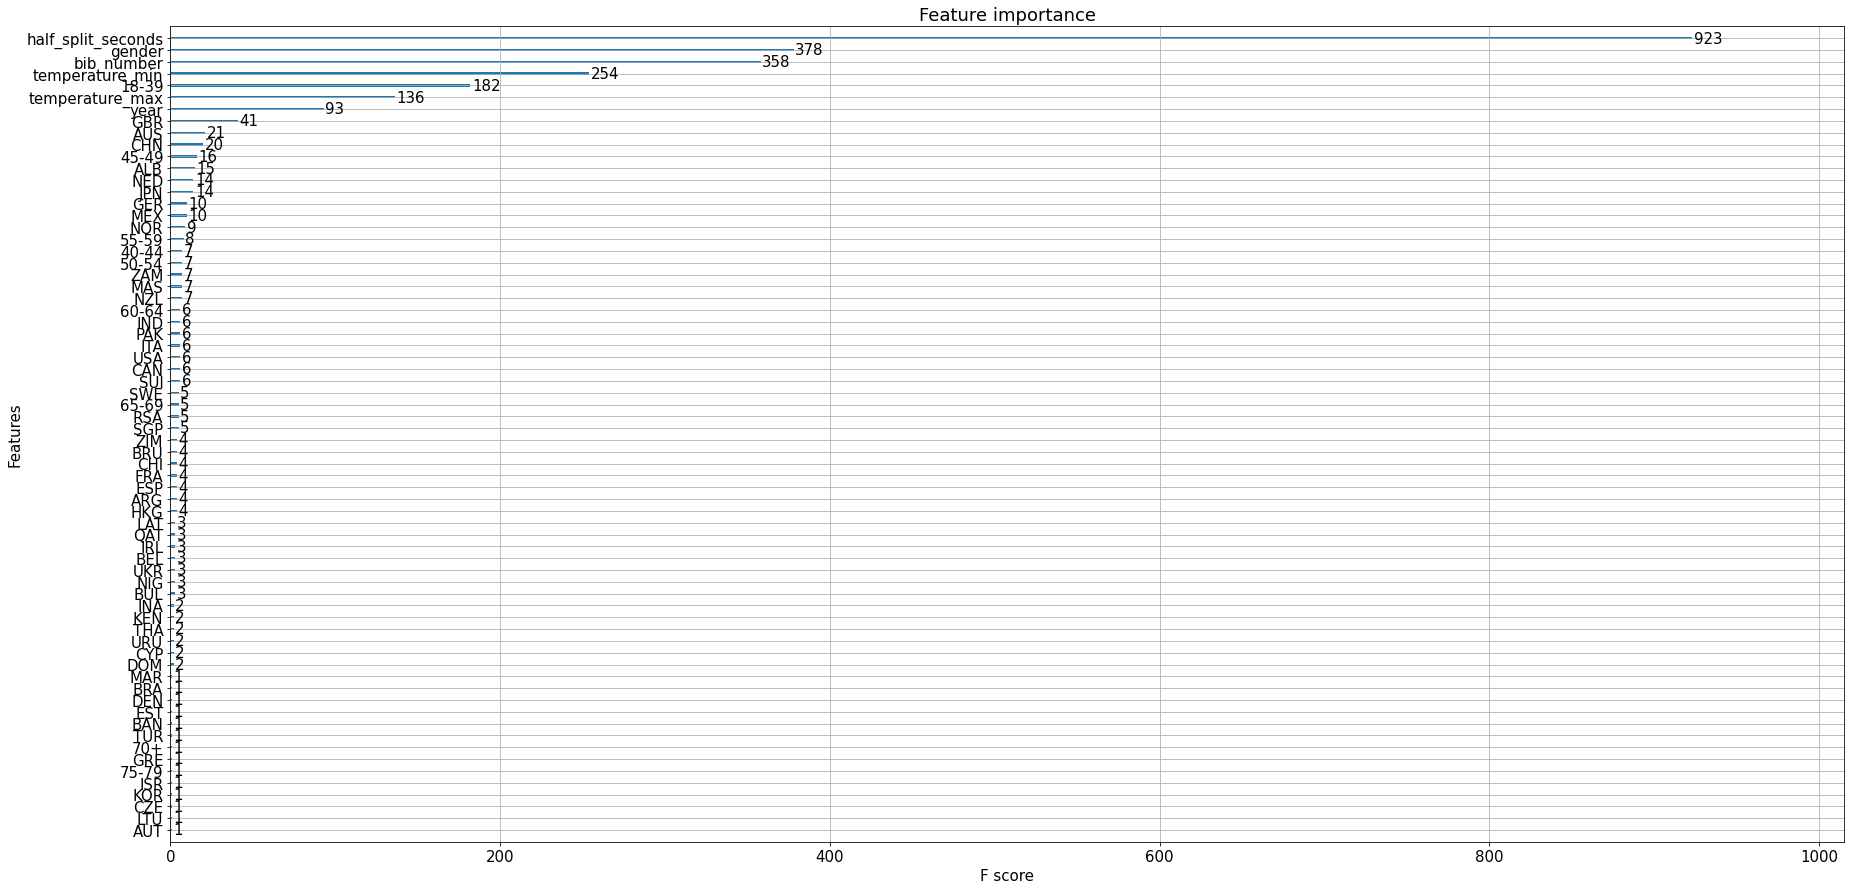

In [144]:
# Look at the importance of each feature
# This provides a full description of the factors being considered in calculating feature importance (F Score): 
# https://github.com/dmlc/xgboost/blob/b4f952b/python-package/xgboost/core.py#L1639-L1661
# NOTE: feature importance is only defined when decision tree is chosen as the base learner ("booster=gbtree"), and
# not for linear base learners (eg. "booster=gblinear")

xgb.plot_importance(london_no_outliers_xgb_gbtree_final)
plt.rcParams['figure.figsize'] = [30, 15]
# Increase font size of labels and axes
plt.rc('font', size=15)
plt.show()

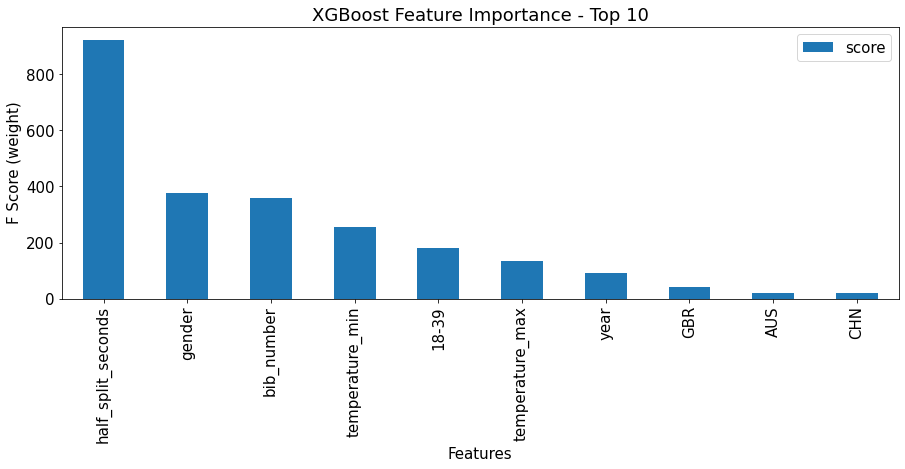

In [159]:
# Extract the top 10 important features above and re-plot
important_features = london_no_outliers_xgb_gbtree_final.get_score(importance_type='weight')
keys = list(important_features.keys())
values = list(important_features.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(10, columns="score").plot(kind='bar', figsize = (15,5), 
                                        xlabel = "Features", ylabel = "F Score (weight)", 
                                        title = "XGBoost Feature Importance - Top 10") ## plot top 15 features
plt.savefig('XGBoost Top 10 Feature Importance .png', dpi=300)

The half split time remains by far the most important feature in the model. Intestingly, by removing outliers, gender becomes the second most important feature over bib number. Minimum temperature and age (18-39) round out the top 5 most important features. 

#### Use the model to calculate mean absolute error for all rows and add as a row in the dataframe

In [129]:
# Convert the train, validation and test sets to DMatrix objects
London_no_outliers_dmatrix = xgb.DMatrix(data = X_London_no_outliers, label = y_London_no_outliers)

# Get Predictions in an array
x = london_no_outliers_xgb_gbtree_final.predict(London_no_outliers_dmatrix)
x

array([8160.2764, 8496.984 , 8688.118 , ..., 9544.857 , 9359.942 ,
       9750.895 ], dtype=float32)

In [130]:
# Add the predictions as a column in the dataframe

london_all_features_no_outliers.loc[:,'predicted_fts'] = x
london_all_features_no_outliers

/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,year,bib_number,elite_status,half_split_seconds,gender,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,...,50-54,55-59,60-64,65-69,70+,70-74,75-79,80-84,85+,predicted_fts
0,2019,1451,0,3904,0,8241,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,8160.276367
1,2019,1291,0,4080,0,8343,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,8496.984375
2,2019,1246,0,4162,0,8403,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,8688.118164
3,2019,1456,0,4170,0,8408,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,8755.910156
4,2019,1362,0,4078,0,8429,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,8496.984375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231957,2017,125,1,4568,1,9491,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,9378.460938
231958,2017,131,1,4528,1,9567,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,9250.349609
231959,2017,132,1,4650,1,9758,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,9544.857422
231960,2017,117,1,4554,1,9811,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,0,9359.942383


In [131]:
# Add a column that calculates Mean Absoluate Error (Actual - Predicted)
london_all_features_no_outliers.loc[:,'mean_abs_error'] = abs(london_all_features_no_outliers['finish_time_seconds'] - london_all_features_no_outliers['predicted_fts'])
london_all_features_no_outliers.head()
                                                        
                                      

/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/bethmcgregor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,year,bib_number,elite_status,half_split_seconds,gender,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,...,55-59,60-64,65-69,70+,70-74,75-79,80-84,85+,predicted_fts,mean_abs_error
0,2019,1451,0,3904,0,8241,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,8160.276367,80.723633
1,2019,1291,0,4080,0,8343,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,8496.984375,153.984375
2,2019,1246,0,4162,0,8403,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,8688.118164,285.118164
3,2019,1456,0,4170,0,8408,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,8755.910156,347.910156
4,2019,1362,0,4078,0,8429,39.75,6.95,5.5,-10.3,...,0,0,0,0,0,0,0,0,8496.984375,67.984375


In [132]:
# Check that there are no negative values
london_all_features_no_outliers['mean_abs_error'].min()

0.0

The model was able to accurately predict some finish times. 

In [133]:
london_all_features_no_outliers['mean_abs_error'].max()

12678.4931640625

However, the worst prediction by the model was off by 3.5 hours!

In [134]:
# Investigate mean absolute error by year
london_all_features_no_outliers.groupby('year').mean()

,bib_number,elite_status,half_split_seconds,gender,finish_time_seconds,altitude_start,altitude_finish,max_slope,min_slope,elevation_gain,...,55-59,60-64,65-69,70+,70-74,75-79,80-84,85+,predicted_fts,mean_abs_error
year,,,,,,,,,,,,,,,,,,,,,
2014,32938.355780,0.000843,7485.139204,0.368146,16181.556449,39.75,6.95,5.5,-10.3,137.4,...,0.035131,0.018662,0.008431,0.004525,0.000000,0.000000,0.000000,0.0,16048.213867,640.143155
2015,32405.492581,0.001045,7397.853627,0.381267,15778.455298,39.75,6.95,5.5,-10.3,137.4,...,0.036747,0.018240,0.008705,0.004875,0.000000,0.000000,0.000000,0.0,15670.504883,596.872525
2016,32798.595663,0.001189,7450.320384,0.384176,15892.163565,39.75,6.95,5.5,-10.3,137.4,...,0.038255,0.018507,0.008271,0.004963,0.000000,0.000000,0.000000,0.0,15780.630859,589.039506
2017,34153.463108,0.001543,7460.357305,0.358117,16086.263926,39.75,6.95,5.5,-10.3,137.4,...,0.042982,0.020381,0.008824,0.005711,0.000000,0.000000,0.000000,0.0,15939.125000,616.845617
2018,34723.922048,0.000788,7850.655497,0.404175,17240.311426,39.75,6.95,5.5,-10.3,137.4,...,0.045815,0.022424,0.009127,0.000000,0.004398,0.000890,0.000203,0.0,17089.982422,620.055235
2019,37322.517296,0.001354,7490.768710,0.415419,16099.730459,39.75,6.95,5.5,-10.3,137.4,...,0.052697,0.025826,0.010074,0.000000,0.004966,0.001544,0.000285,0.0,15982.214844,601.822948


The mean absolute errors ranged from 589-640 seconds, with the highest mean absolute error in 2014.

In [135]:
# Investigate the mean absolute error by gender
london_all_features_no_outliers.groupby('gender')[['finish_time_seconds','predicted_fts','mean_abs_error']].mean()

,finish_time_seconds,predicted_fts,mean_abs_error
gender,,,
0,15431.356262,15303.792969,641.038915
1,17468.939737,17340.824219,561.516370


The mean absolute error was higher for males vs. females, possibly in part to the fact that there were more male runners vs. females. 

In [440]:
# Investigate the mean absolute error by age category
london_all_features_no_outliers.groupby(['18-39', '40-44','45-49','50-54','55-59','60-64','65-69', '70+', '70-74', '75-79', '80-84', '85+'])[['finish_time_seconds','predicted_fts','mean_abs_error']].mean()

finish_time_seconds  \
18-39 40-44 45-49 50-54 55-59 60-64 65-69 70+ 70-74 75-79 80-84 85+                        
0     0     0     0     0     0     0     0   0     0     1     0           21662.850000   
                                                    1     0     0           19886.890000   
                                              1     0     0     0           18857.185864   
                                          1   0     0     0     0           18770.689008   
                                    1     0   0     0     0     0           17714.678676   
                              1     0     0   0     0     0     0           17029.476270   
                        1     0     0     0   0     0     0     0           16736.611946   
                  1     0     0     0     0   0     0     0     0           16199.808664   
            1     0     0     0     0     0   0     0     0     0           15971.782287   
      1     0     0     0     0     0     0   0     0     0     0           15838.394004   
1     0     0     0     0     0     0     0   0     0     0     0           16281.801065   

                                                                     predicted_fts  \
18-39 40-44 45-49 50-54 55-59 60-64 65-69 70+ 70-74 75-79 80-84 85+                  
0     0     0     0     0     0     0     0   0     0     1     0     21492.390625   
                                                    1     0     0     19778.269531   
                                              1     0     0     0     18721.533203   
                                          1   0     0     0     0     18624.806641   
                                    1     0   0     0     0     0     17602.708984   
                              1     0     0   0     0     0     0     16892.582031   
                        1     0     0     0   0     0     0     0     16588.287109   
                  1     0     0     0     0   0     0     0     0     16082.742188   
            1     0     0     0     0     0   0     0     0     0     15862.676758   
      1     0     0     0     0     0     0   0     0     0     0     15725.771484   
1     0     0     0     0     0     0     0   0     0     0     0     16144.304688   

                                                                     mean_abs_error  
18-39 40-44 45-49 50-54 55-59 60-64 65-69 70+ 70-74 75-79 80-84 85+                  
0     0     0     0     0     0     0     0   0     0     1     0        492.551953  
                                                    1     0     0        607.863799  
                                              1     0     0     0        693.377173  
                                          1   0     0     0     0        657.115974  
                                    1     0   0     0     0     0        648.288065  
                              1     0     0   0     0     0     0        609.071955  
                        1     0     0     0   0     0     0     0        599.898014  
                  1     0     0     0     0   0     0     0     0        571.579006  
            1     0     0     0     0     0   0     0     0     0        559.308617  
      1     0     0     0     0     0     0   0     0     0     0        562.623894  
1     0     0     0     0     0     0     0   0     0     0     0        645.387943

The smallest mean absolute error was for the 80-84 group, possibly because there were relatively few runners in that age class. Interestingly, the 40-44 age category also had lower mean absolute error, even with a higher number of runners. The 18-39 age class had one of the higher mean absolute errors even though it was one of the more important features in the model. 

In [139]:
london_all_features_no_outliers.groupby('elite_status')[['finish_time_seconds','predicted_fts','mean_abs_error']].mean()

,finish_time_seconds,predicted_fts,mean_abs_error
elite_status,,,
0,16227.07926,16099.162109,610.840655
1,8392.40000,8389.101562,158.484071


The model appeared to predict quite well on average for elite runners. The mean absolute error for elites was 159.5 seconds which is just under 3 minutes. 

#### Conclusions

I found that an using an XGBoost model on a dataset with outliers removed provide the best performing model. The model was able to predict finish times within approximately 614 seconds (just over 10 minutes). The top five most important features of this model were: half split time, gender, bib number, minimum temperature and age class (18-39). Interestingly, this model is better able to predict elite finish times better vs. non-elite finish times (158 vs. 611 seconds mean absolute errors). 